In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

from docplex.mp.model import Model as CplexModel
import docplex.mp.solution as CplexSol

import gurobipy as gb

## Leitura dos dados

In [2]:
xlsx = pd.ExcelFile('Dados trab PO1.xlsx')
df1 = pd.read_excel(xlsx, 'Pontos Turisticos')
df2 = pd.read_excel(xlsx, 'Recompensa por horario', header=None)
df3 = pd.read_excel(xlsx, 'Custo (reais)', header=None)
df4 = pd.read_excel(xlsx, 'Tempo (min)', header=None)

In [3]:
'''
toy_size = 15
df1 = df1.head(toy_size)
df2 = df2.loc[:toy_size,:]
df3 = df3.loc[:toy_size,:toy_size]
df4 = df4.loc[:toy_size,:toy_size]
'''

In [4]:
df1

,Id,Nome,Custo Fixo,Abre - horario,Fecha - horario,Permanecia,Avaliacao,Preferencia
0,1,Corcovado,82.0,8.0,19.0,2.00,4.5,Tarde
1,2,Mirante Dona Marta,0.0,8.0,17.0,2.00,4.5,Manha
2,3,Pão de Açúcar,104.4,8.0,21.0,2.00,4.5,Tarde
3,4,Forte de Copacabana,6.0,10.0,18.0,1.66,4.5,Tarde
4,5,Praia de Copacabana,0.0,7.0,19.0,3.00,4.5,Manha
5,6,Pedra do Arpoador,0.0,7.0,19.0,1.66,4.5,Tarde
6,7,Praia de Ipanema,0.0,8.0,17.0,3.00,4.5,Manha
7,8,Mirante do Leblon,0.0,7.0,19.0,1.66,4.5,Tarde
8,9,Parque Dois Irmãos,0.0,8.0,22.0,1.66,4.5,Tarde
9,10,Morro Dois Irmãos,0.0,7.0,19.0,3.00,5.0,Manha


In [5]:
startingPoint = 4

df1.at[startingPoint, 'Nome'] = 'Hotel (na praia de Copacabana)'
df1.at[startingPoint,'Abre - horario'] = 9
df1.at[startingPoint,'Fecha - horario'] = 22
df1.at[startingPoint,'Permanecia'] = 0
df1.at[startingPoint,'Custo Fixo'] = 0
df1.at[startingPoint,'Avaliacao'] = 0

In [6]:
CF = np.asarray(df1['Custo Fixo'], dtype=float)       #custo fixo
Ta = np.asarray(df1['Abre - horario'], dtype=float)   #tempo de abertura da janela
Tf = np.asarray(df1['Fecha - horario'], dtype=float)  #tempo de encerramento da janela
Tp = np.asarray(df1['Permanecia'], dtype=float)       #tempo de permanencia em um ponto
RS = np.asarray(df1['Avaliacao'], dtype=float)        #recompensa fixa
RO = np.asarray(df2, dtype=float)                     #recompensa por tempo de chegada
R_max = RS.max() + RO.max()                           #recompensa maxima
C = np.asarray(df3, dtype=float)                      #custo de viagem entre dois pontos
CV_max = C.max()                                      #custo de viagem maximo
CF_max = CF.max()                                     #custo fixo maximo
Td = np.asarray(df4, dtype=float) / 60                #tempo de deslocamento entre dois pontos (em horas)
O = startingPoint                                     #ponto de origem
T_max = float(Tf[O])                                  #horario max de chagada em um ponto
B = 1000000                                           #valor auxiliar
N = len(df1)                                          #quantidade de pontos
D = 3                                                 #quantidade de dias para visita
K = len(df2.columns)                                  #quantidade de janelas de tempo para recompensa (tabela RO)
C_limit = 200                                         #limite de custo

## Plot do grafo baseado no custo e no tempo

### Custo de viagem

In [7]:
G = nx.from_numpy_matrix(C)
pos = nx.spring_layout(G)
pos_c = nx.kamada_kawai_layout(G, dist=C)

In [8]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
#nx.draw(G, pos=pos, **options)

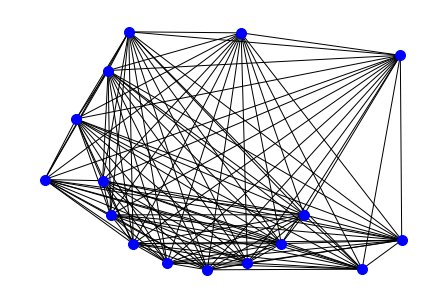

In [9]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G, pos=pos_c, **options)

### Tempo de viagem

In [10]:
G2 = nx.from_numpy_matrix(Td)
pos = nx.spring_layout(G2)
pos_t = nx.kamada_kawai_layout(G2, dist=Td * 60)

In [11]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
#nx.draw(G2, pos=pos, **options)

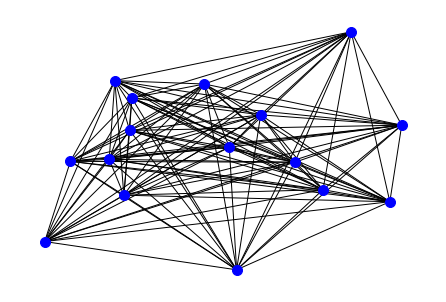

In [12]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G2, pos=pos_t, **options)

## Modelagem

### Parâmetros

$Ta_i$: Tempo de abertura para visitar $i$

$Tf_i$: Tempo de encerramento para visita $i$ 

$Tp_i$: Tempo de permanência na visita de $i$ 

$Td_{i,j}$: Tempo de deslocamento entre $i$ e $j$

$T_{max}$: Tempo máximo para voltar a origem 

$RS_i$: Recompensa fixa por visitar $i$

$RO_{i,k}$: Recompensa por visitar $i$ na janela $k$ (entre $k$ e $k+1$)

$R_{max}$: Recomensa máxima para normalizar na F.O.

$C_{i,j}$: Custo de deslocamento entre $i$ e $j$

$CV_{max}$: Custo máximo de deslocamento para normalizar na F.O.

$CF_i$: Custo fixo para visitar $i$

$CF_{max}$: Custo fixo máximo para normalizar na F.O.

$O$: Ponto de origem (vértice inicial e final de todos os dias)

$D$: Quantidade de dias

$K$: Quantidade de janelas de tempo para recompensa (dimensão 2 de $RO_{i,k}$) 

$N$: Quantidade de pontos turísticos (incluindo origem)

$Custo_{max}$: Custo máximo para solução (orçamento para todos os dias juntos)

$B$: Valor auxiliar utilizado na formulação

### Variáveis

$x_{i,j} = 
\begin{cases}
    1 & \text{se há o deslocamento do ponto } i \text{ para } j \\
    0 & \text{caso contrário}
\end{cases}$

$y_{i,k} = 
\begin{cases}
    1 & \text{se o turista chaga no ponto } i \text{ entre } k \text{ e } k+1 \\
    0 & \text{caso contrário}
\end{cases}$

$t_i \geq 0 \text{,  momento de chegada no ponto } i $

### Formulação


\begin{align}
Max \quad & \sum_{k \in K} \sum_{i \in N} \left( \frac{RO_{i,k} + RS_i}{R_{max}} \right)y_{i,k} - \sum_{i \in N} \sum_{j \in N : i \neq j} \left( \frac{C_{i,j}}{CV_{max}} + \frac{CF_i}{CF_{max}} \right)x_{i,j} \\
S.A. \quad & x_{i,j} \leq 1, \forall i \in N, j \in N \\
     \quad & \sum_{j \in N} x_{i,j} = \sum_{k \in K} y_{i,k}, \forall i \in N : i \neq O \\
     \quad & \sum_{i \in N} x_{i,j} = \sum_{k \in K} y_{j,k}, \forall j \in N : j \neq O \\
     \quad & \sum_{j \in N} x_{O,j} = D \\
     \quad & \sum_{i \in N} x_{i,O} = D \\
     \quad & \sum_{k \in K} y_{i,k} \leq 1, \forall i \in N \\
     \quad & B - B\sum_{k \in K} y_{i,k} + t_i \geq Ta_i, \forall i \in N \\
     \quad & t_i + Tp_i - B + B\sum_{k \in K}y_{i,k} \leq Tf_i, \forall i \in N \\
     \quad & t_j - t_i - B x_{i,j} \geq -B + Td_{i,j} + Tp_i, \forall i \in N, j \in N : j \neq O \\
     \quad & t_i + Tp_i + Td_{i,O} \leq T_{max}, \forall i \in N \\
     \quad & t_i \leq B\sum_{k \in K}y_{i,k}, \forall i \in N \\
     \quad & t_i < 1 + \sum_{k \in K}k y_{i,k}, \forall i \in N \\
     \quad & t_i \geq \sum_{k \in K}k y_{i,k}, \forall i \in N \\
     \quad & \sum_{j \in N} \sum_{i \in N} C_{i,j}x_{i,j} + \sum_{i \in N} (CF_i \sum_{k \in K} y_{i,k}) \leq Custo_{max}
\end{align}


Interpretações:

- 1: Função objetivo maximiza recompensa pela visita dos pontos turísicos menos o custo

- 2: só podemos ir de $i$ para $j$ no máximo 1 vez

- 3 e 4: se um ponto $i$ é visitado, só temos uma chegada e uma saida de $i$ (um ponto turístico não é visitado mais de 1 vez)

- 5 e 6: com temos D rotas (uma rota por dia para visitas), chegamos e saimos da origem D vezes

- 7: como um ponto só é visitado no máximo uma vez, o tempo de chegada nele só pode ter ocorrido em uma janela de tempo

- 8: o tempo de chegada em um ponto tem que ser após sua abertura

- 9: se um ponto $i$ é visitado, temos que chegar nele no máximo $Tp_i$ (tempo de permanência em $i$) antes de ser fechado

- 10: a diferença de tempo de chegada entre dois pontos visitados consecutivamente é pelo menos o deslocamento entre eles mais a permanência no primeiro

- 11: dado que temos que voltar para origem no máximo em $T_{max}$, o tempo de chegada em um ponto $i$ deve considerar o tempo de permanência em $i$ e o deslocamento para a origem

- 12: se um ponto $i$ não é visitado, colocamos o tempo de chegada em $i$ como 0

- 13 e 14: restrições para determinar a janela de tempo da chegada nos pontos turísticos

- 15: o custo dos deslocamentos mais as entradas nos pontos visitados não pode ser maior que o orçamento disponível

## Implementação

### Gurobi

In [13]:
model = gb.Model("PCTSP_gurobi")

x = model.addVars(N, N, vtype = gb.GRB.BINARY, name='x')
y = model.addVars(N, K, vtype = gb.GRB.BINARY, name ='y')
t = model.addVars(N, vtype = gb.GRB.CONTINUOUS, name ='t')

t[O] = float(Ta[O])
for i in range(N):
    x[i,i] = 0

model.setObjective(gb.quicksum(gb.quicksum(((RO[i,k] + RS[i])/R_max)*y[i,k] for i in range(N) if i != O) for k in range(K)) - gb.quicksum(gb.quicksum((C[i,j]/CV_max + CF[i]/CF_max)*x[i,j] for i in range(N)) for j in range(N)), gb.GRB.MAXIMIZE) 

#model.addConstr(t[O] >= Ta[O])
model.addConstrs(x[i,j] <= 1 for i in range(N) for j in range(N))
model.addConstrs(gb.quicksum(x[i,j] for j in range(N)) == gb.quicksum(y[i,k] for k in range(K)) for i in range(N) if i != O)
model.addConstrs(gb.quicksum(x[i,j] for i in range(N)) == gb.quicksum(y[j,k] for k in range(K)) for j in range(N) if j != O)
model.addConstr(gb.quicksum(x[O,j] for j in range(N)) == D)
model.addConstr(gb.quicksum(x[i,O] for i in range(N)) == D)
model.addConstrs(gb.quicksum(y[i,k] for k in range(K)) <= 1 for i in range(N))
model.addConstrs(t[i] + Tp[i] + Td[i,O] <= T_max for i in range(N) if i != O)
model.addConstrs(B - B*gb.quicksum(y[i,k] for k in range(K)) + t[i] >= Ta[i] for i in range(N))
model.addConstrs(t[i] + Tp[i] - B + B*gb.quicksum(y[i,k] for k in range(K)) <= Tf[i] for i in range(N))
model.addConstrs(t[j] - t[i] - B*x[i,j] >= -B + Td[i,j] + Tp[i] for i in range(N) for j in range(N) if j != O)
model.addConstrs(t[i] <= B*gb.quicksum(y[i,k] for k in range(K)) for i in range(N))
model.addConstrs(t[i] + 0.01 <= gb.quicksum(k*y[i,k] for k in range(K)) + 1 for i in range(N))
model.addConstrs(t[i] >= gb.quicksum(k*y[i,k] for k in range(K)) for i in range(N))
model.addConstr(gb.quicksum(gb.quicksum(C[i,j]*x[i,j] for i in range(N)) for j in range(N)) + gb.quicksum(CF[i]*gb.quicksum(y[i,k] for k in range(K)) for i in range(N)) <= C_limit)

model.Params.timeLimit = 1200 # TEMPO DE EXECUÇÃO
# model.Params.MIPGap = 0.1
model.optimize()

Restricted license - for non-production use only - expires 2023-10-25
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 570 rows, 600 columns and 4396 nonzeros
Model fingerprint: 0xf19cafb4
Variable types: 15 continuous, 585 integer (585 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 273 rows and 236 columns
Presolve time: 0.02s
Presolved: 297 rows, 364 columns, 1847 nonzeros
Variable types: 14 continuous, 350 integer (350 binary)
Found heuristic solution: objective -0.0857908

Root relaxation: objective 8.623441e+00, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

In [14]:
print("função objetivo:", str(round(model.ObjVal,2)))
print("gap:", model.MIPGap * 100)
print("tempo:", model.Runtime)

for v in model.getVars():
    name = str(v.VarName)
    value = v.getAttr(gb.GRB.Attr.X)
    if value > 0:
        print(name +"="+ str(value))
        
x_sol = np.zeros((N,N))
y_sol = np.zeros((N,K))
t_sol = np.zeros((N))

for i in range(N):
    t_sol[i] = t[O] if i == O else t[i].x
    for j in range(N):
        if i != j:
            x_sol[i][j] = x[i,j].x
    for k in range(K):
        y_sol[i][k] = y[i,k].x

função objetivo: 7.06
gap: 0.0
tempo: 12.467853546142578
x[1,3]=1.0
x[3,5]=1.0
x[4,6]=1.0
x[4,11]=1.0
x[4,13]=1.0
x[5,4]=1.0
x[6,9]=1.0
x[7,4]=1.0
x[8,7]=1.0
x[9,8]=1.0
x[10,4]=1.0
x[11,1]=1.0
x[12,10]=1.0
x[13,12]=1.0
y[1,11]=1.0
y[3,14]=1.0
y[4,9]=1.0
y[5,15]=1.0
y[6,9]=1.0
y[7,17]=1.0
y[8,15]=1.0
y[9,12]=1.0
y[10,16]=1.0
y[11,9]=1.0
y[12,13]=1.0
y[13,9]=1.0
t[1]=11.316666666612335
t[3]=14.279999999965847
t[5]=15.989999999999997
t[6]=9.150000000023283
t[7]=17.226666666716337
t[8]=15.46666666668995
t[9]=12.34999999993791
t[10]=16.51666666675205
t[11]=9.099999999976715
t[12]=13.433333333387672
t[13]=9.349999999976715


In [15]:
edges = []

for i in range(N):
    for j in range(N):
        if i != j and x_sol[i][j] > 0:
            edges.append((i,j))
                
print("Arestas:", edges)

vertices = []
arestas = edges.copy()
rotas = []
vertices_rotas = []
for d in range(D):
    rota = []
    v = startingPoint
    v_rota = [v]
    while len(rota) == 0 or v != startingPoint:
        for e in arestas:
            if e[0] == v:
                rota.append(e)
                arestas.remove(e)
                v = e[1]
                if v != startingPoint:
                    vertices.append(v)
                    v_rota.append(v)
                break
    rotas.append(rota)
    vertices_rotas.append(v_rota)
                
print("Vertices:", vertices)

cost = 0
for v in vertices:
    cost += CF[v]
for e in edges:
    cost += C[e]
#print("Custo total:", cost)
            
#rotas

Arestas: [(1, 3), (3, 5), (4, 6), (4, 11), (4, 13), (5, 4), (6, 9), (7, 4), (8, 7), (9, 8), (10, 4), (11, 1), (12, 10), (13, 12)]
Vertices: [6, 9, 8, 7, 11, 1, 3, 5, 13, 12, 10]


In [16]:
for d in range(D):
    locais = [df1.at[v, 'Nome'] for v in vertices_rotas[d]]
    tempos = [round(t[O] if v == O else t_sol[v], 2) for v in vertices_rotas[d]]
    preferencias = [df1.at[v, 'Preferencia'] for v in vertices_rotas[d]]
    permanencias = [df1.at[v, 'Permanecia'] for v in vertices_rotas[d]]
    deslocamento = [round(Td[e],2) for e in rotas[d]]
    custo_entrada = [df1.at[v, 'Custo Fixo'] for v in vertices_rotas[d]]
    
    #df = pd.DataFrame({'Tempo': tempos, 'Nome': locais, 'Vertice': vertices_rotas[d]})
    df = pd.DataFrame({'Tempo': tempos, 'Nome': locais, 'Vertice': vertices_rotas[d], 'Permanencia': permanencias, 'Deslocamento': deslocamento, 'Preferencia': preferencias, 'Custo Entrada': custo_entrada})
    print('DIA', d+1)
    print(df.to_string(index=True))
    print()

print("Custo total:", round(cost, 2))

DIA 1
   Tempo                            Nome  Vertice  Permanencia  Deslocamento Preferencia  Custo Entrada
0   9.00  Hotel (na praia de Copacabana)        4         0.00          0.15       Manha            0.0
1   9.15                Praia de Ipanema        6         3.00          0.20       Manha            0.0
2  12.35               Morro Dois Irmãos        9         3.00          0.12       Manha            0.0
3  15.47              Parque Dois Irmãos        8         1.66          0.10       Tarde            0.0
4  17.23               Mirante do Leblon        7         1.66          0.23       Tarde            0.0

DIA 2
   Tempo                            Nome  Vertice  Permanencia  Deslocamento Preferencia  Custo Entrada
0   9.00  Hotel (na praia de Copacabana)        4         0.00          0.10       Manha            0.0
1   9.10             Parque da Catacumba       11         2.00          0.22       Manha            0.0
2  11.32              Mirante Dona Marta        1  

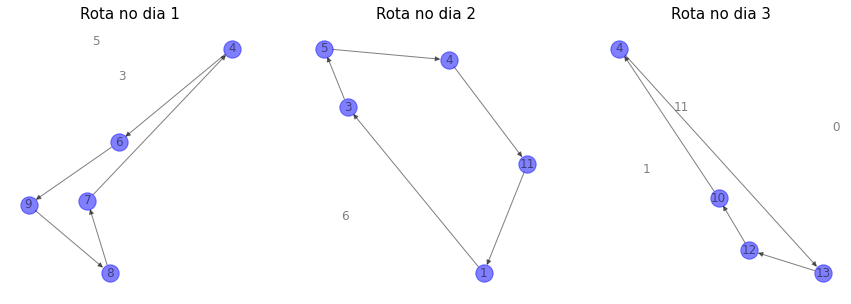

In [17]:
options = {
    'node_color': 'blue',
    'node_size': 300,
    'alpha': 0.5,
    'width': 1,
}

f = plt.figure(figsize=(15,5))
for d in range(D):
    subax = f.add_subplot(1, D, d+1)
    subax.set_title('Rota no dia '+str(d+1), fontsize=15)
    nx.draw(G, pos=pos_t, nodelist=vertices_rotas[d], edgelist=rotas[d], with_labels=True, arrows=True, ax=subax, **options)
    
#FALTA COLOCAR O MAPA DE FUNDO E OS PONTOS NAS COORDENADAS ESPECIFICAS

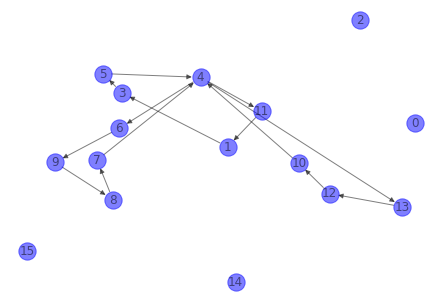

In [18]:
options = {
    'node_color': 'blue',
    'node_size': 300,
    'alpha': 0.5,
    'width': 1,
}

nx.draw(G, pos=pos_t, edgelist=edges, with_labels=True, arrows=True, **options)

### Cplex

In [19]:
v_x = [(i,j) for i in range(N) for j in range(N)]
v_y = [(i,k) for i in range(N) for k in range(K)]
v_t = [i for i in range(N)]

mdl = CplexModel('PCTSP_cplex')

x = mdl.binary_var_dict(v_x, name='x')
y = mdl.binary_var_dict(v_y, name='y')
t = mdl.continuous_var_dict(v_t, name='t')

t[O] = Ta[O]
for i in range(N):
    x[i,i] = 0

mdl.maximize(mdl.sum(mdl.sum(((RO[i,k] + RS[i])/R_max)*y[(i,k)] for i in range(N) if i != O) for k in range(K)) - mdl.sum(mdl.sum((C[i,j]/CV_max + CF[i]/CF_max)*x[(i,j)] for i in range(N)) for j in range(N)))

for i in range(N):
    for j in range(N):
        mdl.add_constraint(x[(i,j)] <= 1)
        
        if j != O:
            mdl.add_constraint(t[j] - t[i] - B*x[(i,j)] >= -B + Td[i,j] + Tp[i])
    
for i in range(N):
    mdl.add_constraint(mdl.sum(y[(i,k)] for k in range(K)) <= 1)
    mdl.add_constraint(B - B*mdl.sum(y[(i,k)] for k in range(K)) + t[i] >= Ta[i])
    mdl.add_constraint(t[i] + Tp[i] - B + B*mdl.sum(y[(i,k)] for k in range(K)) <= Tf[i])
    mdl.add_constraint(t[i] <= B*mdl.sum(y[(i,k)] for k in range(K)))
    mdl.add_constraint(t[i] + 0.01 <= mdl.sum(k*y[(i,k)] for k in range(K)) + 1)
    mdl.add_constraint(t[i] >= mdl.sum(k*y[(i,k)] for k in range(K)))
    
    if i != O:
        mdl.add_constraint(t[i] + Tp[i] + Td[i,O] <= T_max)
        mdl.add_constraint(mdl.sum(x[(i,j)] for j in range(N)) == mdl.sum(y[(i,k)] for k in range(K)))
        mdl.add_constraint(mdl.sum(x[(j,i)] for j in range(N)) == mdl.sum(y[(i,k)] for k in range(K)))

mdl.add_constraint(mdl.sum(x[(O,j)] for j in range(N)) == D)
mdl.add_constraint(mdl.sum(x[(i,O)] for i in range(N)) == D)
mdl.add_constraint(mdl.sum(mdl.sum(C[i,j]*x[(i,j)] for i in range(N)) for j in range(N)) + mdl.sum(CF[i]*mdl.sum(y[i,k] for k in range(K)) for i in range(N)) <= C_limit)

mdl.parameters.timelimit = 30
# mdl.parameters.mip.strategy.branch=1
# mdl.parameters.mip.tolerances.mipgap=0.15

#cplex tem um limite de 1000 var e 1000 const
print('Variables =', mdl.number_of_variables)
print('Constraints =', mdl.number_of_constraints)

Variables = 600
Constraints = 555


In [20]:
solution = mdl.solve(log_output=True)
#print(mdl.export_to_string())

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               30
Tried aggregator 1 time.
MIP Presolve eliminated 245 rows and 97 columns.
MIP Presolve modified 1016 coefficients.
Reduced MIP has 310 rows, 503 columns, and 3525 nonzeros.
Reduced MIP has 489 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.94 ticks)
Found incumbent of value 0.662676 after 0.01 sec. (5.69 ticks)
Probing fixed 149 vars, tightened 0 bounds.
Probing time = 0.00 sec. (1.69 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 24 rows and 149 columns.
MIP Presolve modified 1042 coefficients.
Reduced MIP has 286 rows, 354 columns, and 2084 nonzeros.
Reduced MIP has 340 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.67 ticks)
Probing time = 0.00 sec. (0.93 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 286 rows, 354 columns, and 2084 non

Tried aggregator 1 time.
Reduced MIP has 269 rows, 354 columns, and 3680 nonzeros.
Reduced MIP has 340 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.89 ticks)
Represolve time = 0.05 sec. (17.59 ticks)
  48175     0        7.8154    81        6.7641      Cuts: 21   621592    9.27%
  48175     0        7.8152    81        6.7641      Cuts: 21   621606    9.27%
  48175     0        7.8137    70        6.7641       Cuts: 9   621626    9.27%
  48175     0        7.8121    81        6.7641      Cuts: 42   621652    9.27%
  48175     0        7.8115    84        6.7641      Cuts: 29   621674    9.27%
  48175     0        7.8106    75        6.7641      Cuts: 10   621700    9.27%
  48175     0        7.8102    80        6.7641      Cuts: 32   621728    9.27%
  48175     0        7.8087    68        6.7641      Cuts: 33   621779    9.27%
  48175     0        7.8085    73        6.7641      Cuts: 26   621807    9.27%
  48175     0        7.8081    70        6.7641 

In [21]:
solution.display()

solution for: PCTSP_cplex
objective: 7.046
x_1_3 = 1
x_3_5 = 1
x_4_6 = 1
x_4_11 = 1
x_4_13 = 1
x_5_4 = 1
x_6_9 = 1
x_7_8 = 1
x_8_4 = 1
x_9_7 = 1
x_10_4 = 1
x_11_1 = 1
x_12_10 = 1
x_13_12 = 1
y_1_11 = 1
y_3_14 = 1
y_4_9 = 1
y_5_16 = 1
y_6_9 = 1
y_7_16 = 1
y_8_17 = 1
y_9_12 = 1
y_10_16 = 1
y_11_9 = 1
y_12_13 = 1
y_13_9 = 1
t_1 = 11.700
t_3 = 14.000
t_5 = 16.990
t_6 = 9.150
t_7 = 16.000
t_8 = 17.990
t_9 = 12.967
t_10 = 16.990
t_11 = 9.100
t_12 = 13.433
t_13 = 9.350


In [22]:
print("tempo:", mdl.solve_details.time)
print("gap:", mdl.solve_details.gap * 100)
print("FO:", mdl.objective_value)

tempo: 30.030999999988126
gap: 2.758195025775575
FO: 7.046174518374615


In [23]:
edges = []

for i in range(N):
    for j in range(N):
        if i != j and x[(i,j)].solution_value > 0:
            edges.append((i,j))
                
print(edges)

[(1, 3), (3, 5), (4, 6), (4, 11), (4, 13), (5, 4), (6, 9), (7, 8), (8, 4), (9, 7), (10, 4), (11, 1), (12, 10), (13, 12)]


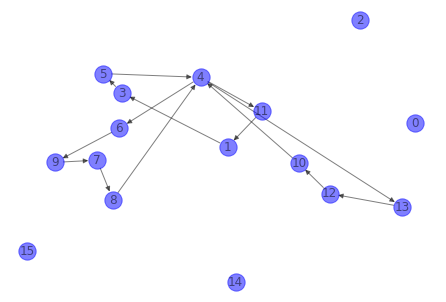

In [24]:
options = {
    'node_color': 'blue',
    'node_size': 300,
    'alpha': 0.5,
    'width': 1,
}

nx.draw(G, pos=pos_t, edgelist=edges, with_labels=True, arrows=True, **options)

## Experimentos

### Comparando gurobi com cplex

In [12]:
xlsx = pd.ExcelFile('Dados trab PO1.xlsx')
df1 = pd.read_excel(xlsx, 'Pontos Turisticos')
df2 = pd.read_excel(xlsx, 'Recompensa por horario', header=None)
df3 = pd.read_excel(xlsx, 'Custo (reais)', header=None)
df4 = pd.read_excel(xlsx, 'Tempo (min)', header=None)

In [13]:
toy_size = 21
df1 = df1.head(toy_size)
df2 = df2.loc[:toy_size,:]
df3 = df3.loc[:toy_size,:toy_size]
df4 = df4.loc[:toy_size,:toy_size]

In [14]:
startingPoint = 4

df1.at[startingPoint, 'Nome'] = 'Hotel (na praia de Copacabana)'
df1.at[startingPoint,'Abre - horario'] = 9
df1.at[startingPoint,'Fecha - horario'] = 22
df1.at[startingPoint,'Permanecia'] = 0
df1.at[startingPoint,'Custo Fixo'] = 0
df1.at[startingPoint,'Avaliacao'] = 0

In [15]:
CF = np.asarray(df1['Custo Fixo'], dtype=float)       #custo fixo
Ta = np.asarray(df1['Abre - horario'], dtype=float)   #tempo de abertura da janela
Tf = np.asarray(df1['Fecha - horario'], dtype=float)  #tempo de encerramento da janela
Tp = np.asarray(df1['Permanecia'], dtype=float)       #tempo de permanencia em um ponto
RS = np.asarray(df1['Avaliacao'], dtype=float)        #recompensa fixa
RO = np.asarray(df2, dtype=float)                     #recompensa por tempo de chegada
R_max = RS.max() + RO.max()                           #recompensa maxima
C = np.asarray(df3, dtype=float)                      #custo de viagem entre dois pontos
CV_max = C.max()                                      #custo de viagem maximo
CF_max = CF.max()                                     #custo fixo maximo
Td = np.asarray(df4, dtype=float) / 60                #tempo de deslocamento entre dois pontos (em horas)
O = startingPoint                                     #ponto de origem
T_max = float(Tf[O])                                  #horario max de chagada em um ponto
B = 1000000                                           #valor auxiliar
N = len(df1)                                          #quantidade de pontos
D = 3                                                 #quantidade de dias para visita
K = len(df2.columns)                                  #quantidade de janelas de tempo para recompensa (tabela RO)
C_limit = 200                                         #limite de custo

In [16]:
sizes = [6,12,18] #[6,12,18,25,35]

In [17]:
data = {
    "n_points": [],
    "teste_index": [],
    "days": [],
    "gb_time": [],
    "gb_gap": [],
    "gb_fo": [],
    "cplex_time": [],
    "cplex_gap": [],
    "cplex_fo": [],
    "points": []
}

results_df = pd.DataFrame(data)

In [18]:
for size in sizes:
    for test in range(3) if sizes[0] != 35 else range(1):
        points = list(range(N))
        points.remove(O)
        points = random.sample(points, size - 1)
        points.append(O)
        for days in [1,3]:
            print("TESTE - ", size, test, days)
            D = days + 1
            
            #GUROBI
            model = gb.Model("PCTSP_gurobi")

            x = model.addVars(N, N, vtype = gb.GRB.BINARY, name='x')
            y = model.addVars(N, K, vtype = gb.GRB.BINARY, name ='y')
            t = model.addVars(N, vtype = gb.GRB.CONTINUOUS, name ='t')

            t[O] = float(Ta[O])
            for i in range(N):
                x[i,i] = 0

            model.setObjective(gb.quicksum(gb.quicksum(((RO[i,k] + RS[i])/R_max)*y[i,k] for i in points if i != O) for k in range(K)) - gb.quicksum(gb.quicksum((C[i,j]/CV_max + CF[i]/CF_max)*x[i,j] for i in points) for j in points), gb.GRB.MAXIMIZE) 

            #model.addConstr(t[O] >= Ta[O])
            model.addConstrs(x[i,j] <= 1 for i in points for j in points)
            model.addConstrs(gb.quicksum(x[i,j] for j in points) == gb.quicksum(y[i,k] for k in range(K)) for i in points if i != O)
            model.addConstrs(gb.quicksum(x[i,j] for i in points) == gb.quicksum(y[j,k] for k in range(K)) for j in points if j != O)
            model.addConstr(gb.quicksum(x[O,j] for j in points) == D)
            model.addConstr(gb.quicksum(x[i,O] for i in points) == D)
            model.addConstrs(gb.quicksum(y[i,k] for k in range(K)) <= 1 for i in points)
            model.addConstrs(t[i] + Tp[i] + Td[i,O] <= T_max for i in points if i != O)
            model.addConstrs(B - B*gb.quicksum(y[i,k] for k in range(K)) + t[i] >= Ta[i] for i in points)
            model.addConstrs(t[i] + Tp[i] - B + B*gb.quicksum(y[i,k] for k in range(K)) <= Tf[i] for i in points)
            model.addConstrs(t[j] - t[i] - B*x[i,j] >= -B + Td[i,j] + Tp[i] for i in points for j in points if j != O)
            model.addConstrs(t[i] <= B*gb.quicksum(y[i,k] for k in range(K)) for i in points)
            model.addConstrs(t[i] + 0.01 <= gb.quicksum(k*y[i,k] for k in range(K)) + 1 for i in points)
            model.addConstrs(t[i] >= gb.quicksum(k*y[i,k] for k in range(K)) for i in points)
            model.addConstr(gb.quicksum(gb.quicksum(C[i,j]*x[i,j] for i in points) for j in points) + gb.quicksum(CF[i]*gb.quicksum(y[i,k] for k in range(K)) for i in points) <= C_limit)

            model.Params.timeLimit = 600
            model.optimize()
            
            gb_fo = str(round(model.ObjVal,2))
            gb_gap = model.MIPGap * 100
            gb_time = model.Runtime
            
            cplex_time = -1
            cplex_gap = -1
            cplex_fo = -1
            
            #CPLEX
            v_x = [(i,j) for i in range(N) for j in range(N)]
            v_y = [(i,k) for i in range(N) for k in range(K)]
            v_t = [i for i in range(N)]

            mdl = CplexModel('PCTSP_cplex')

            x = mdl.binary_var_dict(v_x, name='x')
            y = mdl.binary_var_dict(v_y, name='y')
            t = mdl.continuous_var_dict(v_t, name='t')

            t[O] = Ta[O]
            for i in range(N):
                x[i,i] = 0

            mdl.maximize(mdl.sum(mdl.sum(((RO[i,k] + RS[i])/R_max)*y[(i,k)] for i in points if i != O) for k in range(K)) - mdl.sum(mdl.sum((C[i,j]/CV_max + CF[i]/CF_max)*x[(i,j)] for i in points) for j in points))

            for i in points:
                for j in points:
                    mdl.add_constraint(x[(i,j)] <= 1)

                    if j != O:
                        mdl.add_constraint(t[j] - t[i] - B*x[(i,j)] >= -B + Td[i,j] + Tp[i])

            for i in points:
                mdl.add_constraint(mdl.sum(y[(i,k)] for k in range(K)) <= 1)
                mdl.add_constraint(B - B*mdl.sum(y[(i,k)] for k in range(K)) + t[i] >= Ta[i])
                mdl.add_constraint(t[i] + Tp[i] - B + B*mdl.sum(y[(i,k)] for k in range(K)) <= Tf[i])
                mdl.add_constraint(t[i] <= B*mdl.sum(y[(i,k)] for k in range(K)))
                mdl.add_constraint(t[i] + 0.01 <= mdl.sum(k*y[(i,k)] for k in range(K)) + 1)
                mdl.add_constraint(t[i] >= mdl.sum(k*y[(i,k)] for k in range(K)))

                if i != O:
                    mdl.add_constraint(t[i] + Tp[i] + Td[i,O] <= T_max)
                    mdl.add_constraint(mdl.sum(x[(i,j)] for j in points) == mdl.sum(y[(i,k)] for k in range(K)))
                    mdl.add_constraint(mdl.sum(x[(j,i)] for j in points) == mdl.sum(y[(i,k)] for k in range(K)))

            mdl.add_constraint(mdl.sum(x[(O,j)] for j in points) == D)
            mdl.add_constraint(mdl.sum(x[(i,O)] for i in points) == D)
            mdl.add_constraint(mdl.sum(mdl.sum(C[i,j]*x[(i,j)] for i in points) for j in points) + mdl.sum(CF[i]*mdl.sum(y[i,k] for k in range(K)) for i in points) <= C_limit)

            mdl.parameters.timelimit = 600
            mdl.solve(log_output=False)
            
            cplex_time = mdl.solve_details.time
            cplex_gap = mdl.solve_details.gap
            cplex_fo = mdl.objective_value
            
            
            #Salvando resultado
            results_df.loc[len(results_df.index)] = [size, test, D, gb_time, gb_gap*100, gb_fo, cplex_time, cplex_gap*100, cplex_fo, sorted(points)] 

TESTE -  6 0 1
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 120 rows, 966 columns and 1360 nonzeros
Model fingerprint: 0xeb8bf8db
Variable types: 21 continuous, 945 integer (945 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 59 rows and 883 columns
Presolve time: 0.01s
Presolved: 61 rows, 83 columns, 525 nonzeros
Variable types: 5 continuous, 78 integer (78 binary)
Found heuristic solution: objective 2.0438249

Root relaxation: objective 2.863500e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.86350    0    6    2.04382    2.86350  40.1% 

C:\Users\usuario\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TESTE -  6 1 1
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 120 rows, 966 columns and 1360 nonzeros
Model fingerprint: 0x28106f9c
Variable types: 21 continuous, 945 integer (945 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  Objective range  [7e-02, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 59 rows and 887 columns
Presolve time: 0.01s
Presolved: 61 rows, 79 columns, 516 nonzeros
Variable types: 5 continuous, 74 integer (74 binary)
Found heuristic solution: objective 1.9882845

Root relaxation: objective 2.525838e+00, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.52584    0    9    1.98828    2.52584  27.0% 

  MIR: 1

Explored 1 nodes (17 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 2.62432 2.36017 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.624322272826e+00, best bound 2.624322272826e+00, gap 0.0000%
TESTE -  12 0 1
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 966 columns and 3250 nonzeros
Model fingerprint: 0x6ed72af5
Variable types: 21 continuous, 945 integer (945 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [5e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 183 rows and 713 columns
Presolve time: 0.01s
Presolved: 201 rows, 253 columns, 1271 nonzeros
Variable types: 11 continuous, 242 integer (242 binary)
Found heuristic solution: objective -0.2773831

Ro

  Gomory: 2
  Cover: 14
  Implied bound: 3
  MIR: 24
  StrongCG: 4
  Flow cover: 2
  GUB cover: 23
  Inf proof: 4
  RLT: 8
  Relax-and-lift: 5

Explored 699 nodes (7203 simplex iterations) in 0.43 seconds (0.22 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 6.21382 6.20439 6.19496 ... 3.46998

Optimal solution found (tolerance 1.00e-04)
Best objective 6.213824911444e+00, best bound 6.213824911444e+00, gap 0.0000%
TESTE -  12 1 1
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 966 columns and 3298 nonzeros
Model fingerprint: 0x24275f2d
Variable types: 21 continuous, 945 integer (945 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [5e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 183 rows and 721 columns
Presolve time: 0.

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 966 columns and 3250 nonzeros
Model fingerprint: 0xea5462a6
Variable types: 21 continuous, 945 integer (945 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  Objective range  [5e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 209 rows and 734 columns
Presolve time: 0.02s
Presolved: 175 rows, 232 columns, 1146 nonzeros
Variable types: 10 continuous, 222 integer (222 binary)
Found heuristic solution: objective 0.5502841

Root relaxation: objective 6.617336e+00, 69 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    6.61734    0   15    0.55028    6.61734  1103%     -    0s
     0     0    6.57695    0   24

     0     0    5.93688    0   42    4.41960    5.93688  34.3%     -    0s
     0     0    5.93688    0   40    4.41960    5.93688  34.3%     -    0s
H    0     0                       4.9571423    5.93688  19.8%     -    0s
H    0     0                       4.9665763    5.92467  19.3%     -    0s
     0     2    5.92467    0   40    4.96658    5.92467  19.3%     -    0s
*   73    49              31       5.0245008    5.90674  17.6%   9.9    0s
H  141   103                       5.0716706    5.88229  16.0%  10.5    0s
H  243   140                       5.5461989    5.88005  6.02%   9.5    0s
H  396   157                       5.5918593    5.84886  4.60%   9.2    0s
H  428   118                       5.6861989    5.84111  2.72%   9.2    0s
H  468   115                       5.7561989    5.84111  1.48%   9.5    0s

Cutting planes:
  Learned: 6
  Gomory: 6
  Cover: 14
  Implied bound: 4
  Clique: 1
  MIR: 30
  StrongCG: 5
  Flow cover: 2
  GUB cover: 22
  RLT: 10
  Relax-and-lift: 5

Exp

 174622 105015    7.20075   70   64    6.17527    9.57929  55.1%  43.2  240s
 177806 106910    9.23551   49   74    6.17527    9.57584  55.1%  43.3  245s
 180959 109022    9.22140   66   70    6.17527    9.57238  55.0%  43.4  250s
 183734 110982    8.98197   49   66    6.17527    9.56974  55.0%  43.5  255s
 187215 113303    9.32903   58   59    6.17527    9.56749  54.9%  43.5  260s
 190347 115360    8.91085   51   93    6.17527    9.56467  54.9%  43.6  265s
 193418 117325    7.66916   70   37    6.17527    9.56195  54.8%  43.6  270s
 196005 118850    8.93697   60   85    6.17527    9.56002  54.8%  43.8  275s
 198612 120825    7.48284   76   55    6.17527    9.55819  54.8%  44.0  280s
 202147 123158    8.78905   91   57    6.17527    9.55519  54.7%  44.0  285s
 204798 124843    9.06685   32   65    6.17527    9.55231  54.7%  44.0  290s
 208382 127158    8.15871   61   52    6.17527    9.54959  54.6%  44.1  295s
 211197 128939    8.70111   61   54    6.17527    9.54731  54.6%  44.1  300s

     0     0   10.57361    0   53    4.77234   10.57361   122%     -    0s
     0     0   10.56956    0   59    4.77234   10.56956   121%     -    0s
     0     0   10.56248    0   54    4.77234   10.56248   121%     -    0s
H    0     0                       5.0459293   10.56248   109%     -    0s
     0     0   10.56192    0   52    5.04593   10.56192   109%     -    0s
     0     0   10.55956    0   58    5.04593   10.55956   109%     -    0s
H    0     0                       5.6185708   10.55956  87.9%     -    0s
     0     0   10.55956    0   58    5.61857   10.55956  87.9%     -    0s
     0     0   10.55956    0   56    5.61857   10.55956  87.9%     -    0s
     0     0   10.55956    0   53    5.61857   10.55956  87.9%     -    0s
H    0     0                       6.3327218   10.55956  66.7%     -    0s
     0     2   10.51984    0   51    6.33272   10.51984  66.1%     -    0s
H  105    91                       7.0200802   10.51514  49.8%  16.0    0s
H  131   137             

 63194 32667    7.71338   95   29    6.45102   10.31575  59.9%  40.4  105s
 66246 33783    9.21502   68   77    6.45102   10.30345  59.7%  40.9  110s
 69015 35841   10.08962   73   77    6.45102   10.29709  59.6%  41.1  115s
 72464 38082   10.14010   59   70    6.45102   10.28808  59.5%  41.5  120s
 75759 40389    9.47778   48   67    6.45102   10.27900  59.3%  41.6  125s
 78995 42684    9.12137   47   72    6.45102   10.27270  59.2%  41.9  130s
 81872 44963    9.99987   40   60    6.45102   10.26626  59.1%  42.2  135s
 85522 47501    7.61114  107   44    6.45102   10.25996  59.0%  42.1  140s
 88201 49447   10.14981   58   78    6.45102   10.25435  59.0%  42.4  145s
 91234 51574    9.40902   66   81    6.45102   10.24991  58.9%  42.6  150s
H91818 52010                       6.6061136   10.24909  55.1%  42.8  151s
H92428 52222                       6.6761136   10.24746  53.5%  42.9  153s
 93278 52969    8.51272  120   69    6.67611   10.24583  53.5%  42.9  155s
 95581 54817    9.51333  


Time limit reached
Best objective 6.676113641293e+00, best bound 1.005338732740e+01, gap 50.5874%
TESTE -  18 1 3
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 792 rows, 966 columns and 5667 nonzeros
Model fingerprint: 0x49628aef
Variable types: 21 continuous, 945 integer (945 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [4e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 381 rows and 481 columns
Presolve time: 0.05s
Presolved: 411 rows, 485 columns, 2582 nonzeros
Variable types: 17 continuous, 468 integer (468 binary)
Found heuristic solution: objective -0.6798041
Found heuristic solution: objective -0.5326343

Root relaxation: objective 1.209350e+01, 103 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds  

     0     0   10.99867    0   55    4.80449   10.99867   129%     -    0s
     0     0   10.95212    0   53    4.80449   10.95212   128%     -    0s
     0     0   10.95053    0   54    4.80449   10.95053   128%     -    0s
     0     0   10.94989    0   59    4.80449   10.94989   128%     -    0s
     0     0   10.94188    0   42    4.80449   10.94188   128%     -    0s
     0     0   10.91888    0   47    4.80449   10.91888   127%     -    0s
     0     0   10.91888    0   53    4.80449   10.91888   127%     -    0s
     0     0   10.90360    0   39    4.80449   10.90360   127%     -    0s
     0     0   10.89791    0   56    4.80449   10.89791   127%     -    0s
     0     0   10.89779    0   55    4.80449   10.89779   127%     -    0s
     0     0   10.89612    0   55    4.80449   10.89612   127%     -    0s
     0     0   10.89554    0   67    4.80449   10.89554   127%     -    0s
     0     0   10.89554    0   69    4.80449   10.89554   127%     -    0s
     0     0   10.88490  

 302076 197236 infeasible  111         6.98071    9.98236  43.0%  37.6  390s
 305320 199440    9.04785   78   70    6.98071    9.98059  43.0%  37.7  395s
 308199 201450    9.46956   72   80    6.98071    9.97969  43.0%  37.8  400s
 311535 203532    8.61935  104   35    6.98071    9.97828  42.9%  37.8  405s
 314477 205399    9.57647   49   73    6.98071    9.97703  42.9%  37.9  410s
 316950 207055    8.17287  126   56    6.98071    9.97597  42.9%  37.9  415s
 320184 209226    9.46801   94   62    6.98071    9.97430  42.9%  38.0  421s
 323234 211227    9.81663   77   57    6.98071    9.97310  42.9%  38.0  425s
 325892 213023    9.42083   73   70    6.98071    9.97198  42.9%  38.1  430s
 329172 215041    9.50528   86   58    6.98071    9.97061  42.8%  38.1  435s
 331903 216804 infeasible   96         6.98071    9.96950  42.8%  38.2  440s
 335003 218673    9.67445   71   77    6.98071    9.96811  42.8%  38.3  445s
 337726 220534    9.65604   50   55    6.98071    9.96707  42.8%  38.4  450s

     0     0   10.56126    0   62    7.90553   10.56126  33.6%     -    0s
     0     0   10.56118    0   64    7.90553   10.56118  33.6%     -    0s
     0     0   10.55814    0   74    7.90553   10.55814  33.6%     -    0s
     0     0   10.55700    0   67    7.90553   10.55700  33.5%     -    0s
     0     0   10.55700    0   51    7.90553   10.55700  33.5%     -    0s
     0     2   10.54030    0   50    7.90553   10.54030  33.3%     -    0s
H   29    33                       8.0643953   10.48419  30.0%   9.6    0s
H   32    33                       8.1885462   10.48419  28.0%   9.7    0s
H   64    60                       8.2451500   10.48419  27.2%  11.9    0s
H   65    70                       8.3851500   10.48419  25.0%  12.0    0s
H   72    70                       9.4551500   10.48419  10.9%  12.3    0s
H  884   601                       9.4711877   10.41672  10.0%  17.5    2s
H 1058   671                       9.4806217   10.41672  9.87%  18.5    2s
H 1067   621             

In [22]:
round(results_df,2)

,n_points,teste_index,days,gb_time,gb_gap,gb_fo,cplex_time,cplex_gap,cplex_fo,points
0,6.0,0.0,2.0,0.15,0.00,2.65,0.03,0.00,2.65,"[3, 4, 7, 8, 15, 17]"
1,6.0,0.0,4.0,0.06,0.00,2.12,0.02,0.00,2.12,"[3, 4, 7, 8, 15, 17]"
2,6.0,1.0,2.0,0.17,0.00,2.16,0.05,0.00,2.16,"[3, 4, 6, 12, 16, 18]"
3,6.0,1.0,4.0,0.05,0.00,2.04,0.02,0.00,2.04,"[3, 4, 6, 12, 16, 18]"
4,6.0,2.0,2.0,0.17,0.00,2.75,0.08,0.00,2.75,"[3, 4, 6, 12, 13, 18]"
5,6.0,2.0,4.0,0.05,0.00,2.62,0.02,0.00,2.62,"[3, 4, 6, 12, 13, 18]"
6,12.0,0.0,2.0,16.08,0.00,5.66,34.02,0.01,5.66,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 16, 17]"
7,12.0,0.0,4.0,0.44,0.00,6.21,0.92,0.00,6.21,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 16, 17]"
8,12.0,1.0,2.0,18.19,0.00,4.23,49.52,0.01,4.23,"[0, 1, 2, 3, 4, 5, 9, 12, 13, 14, 16, 17]"
9,12.0,1.0,4.0,0.43,0.00,5.34,0.75,0.01,5.34,"[0, 1, 2, 3, 4, 5, 9, 12, 13, 14, 16, 17]"


### Soluções com guborbi

In [23]:
xlsx = pd.ExcelFile('Dados trab PO1.xlsx')
df1 = pd.read_excel(xlsx, 'Pontos Turisticos')
df2 = pd.read_excel(xlsx, 'Recompensa por horario', header=None)
df3 = pd.read_excel(xlsx, 'Custo (reais)', header=None)
df4 = pd.read_excel(xlsx, 'Tempo (min)', header=None)

In [24]:
toy_size = 33
df1 = df1.head(toy_size)
df2 = df2.loc[:toy_size,:]
df3 = df3.loc[:toy_size,:toy_size]
df4 = df4.loc[:toy_size,:toy_size]

In [25]:
startingPoint = 4

df1.at[startingPoint, 'Nome'] = 'Hotel (na praia de Copacabana)'
df1.at[startingPoint,'Abre - horario'] = 9
df1.at[startingPoint,'Fecha - horario'] = 22
df1.at[startingPoint,'Permanecia'] = 0
df1.at[startingPoint,'Custo Fixo'] = 0
df1.at[startingPoint,'Avaliacao'] = 0

In [26]:
CF = np.asarray(df1['Custo Fixo'], dtype=float)       #custo fixo
Ta = np.asarray(df1['Abre - horario'], dtype=float)   #tempo de abertura da janela
Tf = np.asarray(df1['Fecha - horario'], dtype=float)  #tempo de encerramento da janela
Tp = np.asarray(df1['Permanecia'], dtype=float)       #tempo de permanencia em um ponto
RS = np.asarray(df1['Avaliacao'], dtype=float)        #recompensa fixa
RO = np.asarray(df2, dtype=float)                     #recompensa por tempo de chegada
R_max = RS.max() + RO.max()                           #recompensa maxima
C = np.asarray(df3, dtype=float)                      #custo de viagem entre dois pontos
CV_max = C.max()                                      #custo de viagem maximo
CF_max = CF.max()                                     #custo fixo maximo
Td = np.asarray(df4, dtype=float) / 60                #tempo de deslocamento entre dois pontos (em horas)
O = startingPoint                                     #ponto de origem
T_max = float(Tf[O])                                  #horario max de chagada em um ponto
B = 1000000                                           #valor auxiliar
N = len(df1)                                          #quantidade de pontos
D = 3                                                 #quantidade de dias para visita
K = len(df2.columns)                                  #quantidade de janelas de tempo para recompensa (tabela RO)
C_limit = 200                                         #limite de custo

In [27]:
sizes = [6,12,18,25] #[6,12,18,25,35]

In [28]:
data = {
    "n_points": [],
    "teste_index": [],
    "days": [],
    "gb_time": [],
    "gb_gap": [],
    "gb_fo": [],
    "points": []
}

results_df = pd.DataFrame(data)

In [29]:
for size in sizes:
    for test in range(3) if sizes[0] != 35 else range(1):
        points = list(range(N))
        points.remove(O)
        points = random.sample(points, size - 1)
        points.append(O)
        for days in range(3):
            D = days + 1
            
            #GUROBI
            model = gb.Model("PCTSP_gurobi")

            x = model.addVars(N, N, vtype = gb.GRB.BINARY, name='x')
            y = model.addVars(N, K, vtype = gb.GRB.BINARY, name ='y')
            t = model.addVars(N, vtype = gb.GRB.CONTINUOUS, name ='t')

            t[O] = float(Ta[O])
            for i in range(N):
                x[i,i] = 0

            model.setObjective(gb.quicksum(gb.quicksum(((RO[i,k] + RS[i])/R_max)*y[i,k] for i in points if i != O) for k in range(K)) - gb.quicksum(gb.quicksum((C[i,j]/CV_max + CF[i]/CF_max)*x[i,j] for i in points) for j in points), gb.GRB.MAXIMIZE) 

            #model.addConstr(t[O] >= Ta[O])
            model.addConstrs(x[i,j] <= 1 for i in points for j in points)
            model.addConstrs(gb.quicksum(x[i,j] for j in points) == gb.quicksum(y[i,k] for k in range(K)) for i in points if i != O)
            model.addConstrs(gb.quicksum(x[i,j] for i in points) == gb.quicksum(y[j,k] for k in range(K)) for j in points if j != O)
            model.addConstr(gb.quicksum(x[O,j] for j in points) == D)
            model.addConstr(gb.quicksum(x[i,O] for i in points) == D)
            model.addConstrs(gb.quicksum(y[i,k] for k in range(K)) <= 1 for i in points)
            model.addConstrs(t[i] + Tp[i] + Td[i,O] <= T_max for i in points if i != O)
            model.addConstrs(B - B*gb.quicksum(y[i,k] for k in range(K)) + t[i] >= Ta[i] for i in points)
            model.addConstrs(t[i] + Tp[i] - B + B*gb.quicksum(y[i,k] for k in range(K)) <= Tf[i] for i in points)
            model.addConstrs(t[j] - t[i] - B*x[i,j] >= -B + Td[i,j] + Tp[i] for i in points for j in points if j != O)
            model.addConstrs(t[i] <= B*gb.quicksum(y[i,k] for k in range(K)) for i in points)
            model.addConstrs(t[i] + 0.01 <= gb.quicksum(k*y[i,k] for k in range(K)) + 1 for i in points)
            model.addConstrs(t[i] >= gb.quicksum(k*y[i,k] for k in range(K)) for i in points)
            model.addConstr(gb.quicksum(gb.quicksum(C[i,j]*x[i,j] for i in points) for j in points) + gb.quicksum(CF[i]*gb.quicksum(y[i,k] for k in range(K)) for i in points) <= C_limit)

            model.Params.timeLimit = 900
            model.optimize()
            
            gb_fo = str(round(model.ObjVal,2))
            gb_gap = model.MIPGap
            gb_time = model.Runtime
                        
            #Salvando resultado
            results_df.loc[len(results_df.index)] = [size, test, D, gb_time, gb_gap*100, gb_fo, sorted(points)] 

Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 120 rows, 1914 columns and 1384 nonzeros
Model fingerprint: 0x8c126cb4
Variable types: 33 continuous, 1881 integer (1881 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [7e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 58 rows and 1837 columns
Presolve time: 0.01s
Presolved: 62 rows, 77 columns, 491 nonzeros
Variable types: 5 continuous, 72 integer (72 binary)
Found heuristic solution: objective 1.8917065

Root relaxation: objective 3.675431e+00, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.67543    0   10    1.89171    3.67543  94.3%     -    0s

C:\Users\usuario\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 58 rows and 1837 columns
Presolve time: 0.01s
Presolved: 62 rows, 77 columns, 491 nonzeros
Variable types: 5 continuous, 72 integer (72 binary)
Found heuristic solution: objective 1.6886295
Found heuristic solution: objective 2.2165105

Root relaxation: objective 3.378054e+00, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.37805    0    8    2.21651    3.37805  52.4%     -    0s
H    0     0                       3.1903566    3.37805  5.88%     -    0s
H    0     0                       3.3188182    3.37805  1.78%     -    0s
     0     0    3.33873    0    8    3.31882    3.33873  0.60%     -    0s
     0     0    3.33873    0    6    3.31882    3.33873  0.60%     -    0s
H    0     0                       3.3342028    3.33873  0.14%  


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.98448    0   13    2.06887    2.98448  44.3%     -    0s
H    0     0                       2.6207044    2.98448  13.9%     -    0s
H    0     0                       2.8673298    2.98448  4.09%     -    0s
     0     0     cutoff    0         2.86733    2.86733  0.00%     -    0s

Cutting planes:
  Learned: 1
  Cover: 5
  Implied bound: 2
  Clique: 8
  MIR: 2
  GUB cover: 2
  Relax-and-lift: 1

Explored 1 nodes (47 simplex iterations) in 0.10 seconds (0.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 2.86733 2.6207 2.06887 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.867329796640e+00, best bound 2.867329796640e+00, gap 0.0000%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processor

 19175  1784    4.55464   46   27    3.28838    5.01950  52.6%  27.1   10s

Cutting planes:
  Learned: 10
  Gomory: 7
  Cover: 280
  Implied bound: 6
  Projected implied bound: 2
  Clique: 1
  MIR: 37
  StrongCG: 4
  Flow cover: 24
  GUB cover: 62
  Inf proof: 1
  Zero half: 27
  RLT: 6
  Relax-and-lift: 5

Explored 30164 nodes (696530 simplex iterations) in 13.04 seconds (11.32 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 3.28838 3.25615 3.25377 ... 2.07909

Optimal solution found (tolerance 1.00e-04)
Best objective 3.288384910109e+00, best bound 3.288384910109e+00, gap 0.0000%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 1914 columns and 3274 nonzeros
Model fingerprint: 0x5b917931
Variable types: 33 continuous, 1881 integer (1881 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+06]
  O

Variable types: 11 continuous, 232 integer (232 binary)

Root relaxation: objective 7.765656e+00, 85 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.76566    0   25    0.61401    7.76566  1165%     -    0s
H    0     0                       1.2986295    7.76566   498%     -    0s
     0     0    7.71083    0   20    1.29863    7.71083   494%     -    0s
H    0     0                       1.5563218    7.71083   395%     -    0s
     0     0    7.70967    0   24    1.55632    7.70967   395%     -    0s
     0     0    7.67449    0   24    1.55632    7.67449   393%     -    0s
     0     0    7.66841    0   26    1.55632    7.66841   393%     -    0s
     0     0    7.64603    0   30    1.55632    7.64603   391%     -    0s
     0     0    7.64603    0   34    1.55632    7.64603   391%     -    0s
     0     0    7.63027    0 

  9071  4375    6.66556   40   30    6.04113    7.29681  20.8%  17.8    5s
 19806  8436 infeasible   32         6.04113    7.21770  19.5%  19.8   10s
 20623  8603    6.80740   38   70    6.04113    7.21343  19.4%  19.9   15s
 23077  9448 infeasible   69         6.04113    7.21343  19.4%  20.4   20s
 35599 11892    6.69709   50   42    6.04113    7.21343  19.4%  21.3   25s
 47013 13180    6.99552   45   47    6.04113    7.16421  18.6%  22.0   30s
 57654 17180    6.99482   48   33    6.04113    7.13097  18.0%  22.5   35s
 67869 20384    6.82828   55   30    6.04113    7.10350  17.6%  23.0   40s
 77370 23144    6.81795   48   26    6.04113    7.08120  17.2%  23.4   45s
 87501 25839    6.72414   69   40    6.04113    7.06218  16.9%  23.7   50s
 96562 27963    6.63451   66   30    6.04113    7.04507  16.6%  23.9   55s
 105176 29973    6.43727   51   22    6.04113    7.02984  16.4%  24.0   60s
 113213 31744    6.68733   58   43    6.04113    7.01590  16.1%  24.0   65s
 122013 33693     cutof

 815264 26536    6.17162   66   42    6.04113    6.27394  3.85%  21.5  525s
 824412 22869    6.19907   60   38    6.04113    6.25462  3.53%  21.5  530s
 832301 19580    6.12861   62   32    6.04113    6.23582  3.22%  21.4  535s
 841692 14770     cutoff   64         6.04113    6.21024  2.80%  21.3  540s
 853092  8143 infeasible   52         6.04113    6.16694  2.08%  21.2  545s

Cutting planes:
  Learned: 7
  Gomory: 7
  Cover: 1423
  Implied bound: 17
  Projected implied bound: 3
  Clique: 2
  MIR: 149
  StrongCG: 7
  Flow cover: 192
  GUB cover: 104
  Inf proof: 19
  Zero half: 37
  RLT: 4
  Relax-and-lift: 5

Explored 864174 nodes (18194453 simplex iterations) in 548.74 seconds (546.93 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 6.04113 5.90113 5.69026 ... 2.50308

Optimal solution found (tolerance 1.00e-04)
Best objective 6.041125847333e+00, best bound 6.041126373261e+00, gap 0.0000%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5

  5573  2853    6.64217   35   37    3.30121    7.46007   126%  26.9    5s
 12450  6055    7.20317   38   54    3.30121    7.35075   123%  32.8   10s
 17680  7526    6.78009   46   45    3.30121    7.27721   120%  37.0   15s
 21217  8335    7.13136   39   52    3.30121    7.23088   119%  40.0   20s
 21305  8394    5.91471   38  101    3.30121    7.23088   119%  39.9   25s
 24711  8971    7.01747   49   57    3.30121    7.23088   119%  41.3   30s
 28663  9021 infeasible   58         3.30121    7.15448   117%  43.4   35s
 32772  8831    5.62076   70   35    3.30121    7.07565   114%  45.4   40s
 36646  8091    6.65244   62   49    3.30121    7.00684   112%  47.1   45s
 40457  7076 infeasible   54         3.30121    6.91985   110%  48.8   50s
 44445  6266    6.57276   47   39    3.30121    6.83871   107%  50.0   55s
 48359  5798 infeasible   62         3.30121    6.74570   104%  51.3   60s
 52086  6292    6.38381   61   53    3.30121    6.68661   103%  52.0   65s
 55069  6380 infeasible  

 183488 47274    6.75893   51   46    5.99525    6.89532  15.0%  26.5  140s
 189785 48420    6.23340   52   12    5.99525    6.88769  14.9%  26.5  145s
 196307 49475    6.01763   73   29    5.99525    6.88056  14.8%  26.5  150s
 202657 50297    6.47776   54   33    5.99525    6.87319  14.6%  26.4  155s
 209573 51387    6.15013   59   33    5.99525    6.86573  14.5%  26.4  160s
 215247 52301    6.49752   68   50    5.99525    6.85973  14.4%  26.4  165s
 222084 53275    6.47631   55   23    5.99525    6.85199  14.3%  26.4  170s
 228348 54135    6.76169   59   38    5.99525    6.84502  14.2%  26.4  175s
 234415 55117    6.30178   46   27    5.99525    6.83858  14.1%  26.3  180s
 240148 55853 infeasible   47         5.99525    6.83272  14.0%  26.3  185s
 245973 56664    6.18017   56   29    5.99525    6.82691  13.9%  26.3  190s
 252064 57425    6.31397   77   36    5.99525    6.82069  13.8%  26.3  195s
 258865 58299     cutoff   46         5.99525    6.81410  13.7%  26.3  200s
 265432 5898

 889723  5972    6.08050   52   34    5.99525    6.09346  1.64%  23.0  675s

Cutting planes:
  Learned: 7
  Gomory: 5
  Cover: 1227
  Implied bound: 16
  Clique: 7
  MIR: 208
  StrongCG: 16
  Flow cover: 203
  GUB cover: 102
  Inf proof: 12
  Zero half: 47
  RLT: 9
  Relax-and-lift: 4

Explored 897296 nodes (20515142 simplex iterations) in 677.72 seconds (716.06 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 5.99525 5.99525 5.97217 ... 5.25956

Optimal solution found (tolerance 1.00e-04)
Best objective 5.995246094901e+00, best bound 5.995246138566e+00, gap 0.0000%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 1914 columns and 3298 nonzeros
Model fingerprint: 0xf449a137
Variable types: 33 continuous, 1881 integer (1881 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+06]
  Objective range  [

     0     0   12.19771    0   80    2.79020   12.19771   337%     -    0s
     0     0   12.19771    0   80    2.79020   12.19771   337%     -    0s
     0     0   11.99950    0   72    2.79020   11.99950   330%     -    0s
     0     0   11.86777    0   75    2.79020   11.86777   325%     -    0s
     0     0   11.86777    0   77    2.79020   11.86777   325%     -    0s
     0     0   11.84712    0   75    2.79020   11.84712   325%     -    0s
     0     0   11.84384    0   81    2.79020   11.84384   324%     -    0s
     0     0   11.84381    0   84    2.79020   11.84381   324%     -    0s
     0     0   11.84361    0   83    2.79020   11.84361   324%     -    0s
     0     0   11.84361    0   77    2.79020   11.84361   324%     -    0s
     0     2   11.76085    0   75    2.79020   11.76085   322%     -    0s
H   64    57                       2.8601238   11.76085   311%  19.7    0s
H  210   187                       2.8843383   11.70361   306%  18.4    0s
H  494   387             

 186378 59318 infeasible   81         3.72618    8.81467   137%  72.2  465s
 188436 59955    8.57318   53   78    3.72618    8.81075   136%  72.1  470s
 189683 60067    8.34172   81   45    3.72618    8.80708   136%  72.2  475s
 191460 60562    8.40120   85   59    3.72618    8.80101   136%  72.3  480s
 193942 61194 infeasible   76         3.72618    8.79575   136%  72.2  485s
 195714 61683    7.64174   69   52    3.72618    8.78976   136%  72.2  490s
 197546 62220 infeasible   74         3.72618    8.78416   136%  72.2  495s
 199798 62825 infeasible   72         3.72618    8.77825   136%  72.1  500s
 201277 63099    7.74493   71   52    3.72618    8.77354   135%  72.2  505s
 203344 63486 infeasible   76         3.72618    8.76676   135%  72.3  511s
 205105 63913 infeasible   77         3.72618    8.76141   135%  72.3  515s
 206795 64274 infeasible   95         3.72618    8.75667   135%  72.3  520s
 208598 64846    7.79368  121   41    3.72618    8.75279   135%  72.3  525s
 210697 6530

H    0     0                       4.0589331   12.82790   216%     -    0s
     0     0   12.71183    0   41    4.05893   12.71183   213%     -    0s
H    0     0                       4.1289331   12.71183   208%     -    0s
     0     0   12.71162    0   39    4.12893   12.71162   208%     -    0s
     0     0   12.69368    0   38    4.12893   12.69368   207%     -    0s
H    0     0                       4.1568258   12.69368   205%     -    0s
     0     0   12.69111    0   40    4.15683   12.69111   205%     -    0s
     0     0   12.63290    0   47    4.15683   12.63290   204%     -    0s
H    0     0                       4.4168258   12.63290   186%     -    0s
     0     0   12.59009    0   55    4.41683   12.59009   185%     -    0s
     0     0   12.49607    0   52    4.41683   12.49607   183%     -    0s
H    0     0                       4.7387327   12.49607   164%     -    0s
     0     0   12.49279    0   64    4.73873   12.49279   164%     -    0s
     0     0   12.49246  

 168898 75192     cutoff   84         6.81309    9.53274  39.9%  48.7  270s
 172475 77037    8.54553   71   52    6.81309    9.52864  39.9%  48.8  276s
 174508 77992 infeasible   74         6.81309    9.52696  39.8%  48.8  280s
 178094 79824    9.03890   85   66    6.81309    9.52330  39.8%  48.8  285s
 181621 81532    9.27916   89   70    6.81309    9.51937  39.7%  48.8  290s
 184838 83100    8.62627   61   61    6.81309    9.51623  39.7%  48.8  295s
 187863 84619    8.27823   71   41    6.81309    9.51391  39.6%  48.8  300s
 190959 86056    9.02835   71   79    6.81309    9.51093  39.6%  48.8  305s
 194222 87650     cutoff   61         6.81309    9.50747  39.5%  48.8  310s
 197261 89022    8.73274   74   52    6.81309    9.50442  39.5%  48.8  315s
 200318 90455    8.97738  108   43    6.81309    9.50079  39.4%  48.9  320s
 203626 91943    7.65329   68   48    6.81309    9.49819  39.4%  48.9  325s
 206706 93394    9.18349   59   58    6.81309    9.49490  39.4%  48.9  330s
 209827 9490

 484678 219497    7.66411   81   43    6.81309    9.32962  36.9%  48.3  800s
 487394 220535    8.71638   66   54    6.81309    9.32837  36.9%  48.3  805s
 490394 221771    8.75632   73   57    6.81309    9.32693  36.9%  48.3  810s
 493364 223067    8.21293   67   57    6.81309    9.32562  36.9%  48.3  815s
 495976 224246    7.92568   70   34    6.81309    9.32441  36.9%  48.3  820s
 498651 225506    9.29182   66   70    6.81309    9.32328  36.8%  48.3  825s
 500887 226391    6.95069   76   32    6.81309    9.32218  36.8%  48.3  830s
 503980 227573    8.66869   66   62    6.81309    9.32065  36.8%  48.3  835s
 506544 228682 infeasible   65         6.81309    9.31952  36.8%  48.2  840s
 509604 230044    9.03201   74   62    6.81309    9.31822  36.8%  48.2  845s
 512412 231368    8.25798   81   39    6.81309    9.31694  36.8%  48.2  851s
 515024 232497    8.62761   52   57    6.81309    9.31580  36.7%  48.2  855s
 518166 233758    8.49496   75   64    6.81309    9.31437  36.7%  48.2  860s

 387986 146549    9.09746   53   29    8.83614    9.68265  9.58%  19.4  135s
 404360 152162    9.21281   64   34    8.83614    9.67652  9.51%  19.4  140s
 419205 157022    9.62575   79   18    8.83614    9.67112  9.45%  19.4  145s
 435853 162355    8.97226   71   39    8.83614    9.66505  9.38%  19.3  150s
 450662 166667    9.21738   79   32    8.83614    9.65977  9.32%  19.3  155s
 466588 171598 infeasible   68         8.83614    9.65448  9.26%  19.3  160s
 482606 176663    9.57464   73   36    8.83614    9.64946  9.20%  19.3  165s
 499632 181938 infeasible   70         8.83614    9.64438  9.15%  19.3  170s
 515582 186949    9.24418   82   22    8.83614    9.63943  9.09%  19.2  175s
 531379 191915    9.06750   77   28    8.83614    9.63505  9.04%  19.2  180s
 548327 196800    9.46169   71   52    8.83614    9.63025  8.99%  19.2  185s
 564243 202047    9.32214   73   23    8.83614    9.62581  8.94%  19.1  190s
 578568 206182    9.44138   78   30    8.83614    9.62208  8.89%  19.1  195s

 2141592 544336    9.25426   74   34    8.83614    9.39217  6.29%  17.6  620s
 2162025 547355     cutoff   48         8.83614    9.39028  6.27%  17.6  625s
 2182016 550502    9.26839   84   33    8.83614    9.38850  6.25%  17.6  630s
 2202029 553678    9.22489   79   41    8.83614    9.38665  6.23%  17.6  635s
 2221445 556563    9.04939   94   27    8.83614    9.38487  6.21%  17.5  640s
 2241837 559508    9.12967   61   36    8.83614    9.38305  6.19%  17.5  645s
 2262689 562681 infeasible   95         8.83614    9.38125  6.17%  17.5  650s
 2283571 565834    9.31546  103   35    8.83614    9.37937  6.15%  17.5  655s
 2303265 568804    9.24508   64   30    8.83614    9.37764  6.13%  17.5  660s
 2323594 571891    9.09518   76   22    8.83614    9.37586  6.11%  17.5  665s
 2341087 574336 infeasible   82         8.83614    9.37441  6.09%  17.5  670s
 2358254 576922    9.30645   87   23    8.83614    9.37299  6.08%  17.5  675s
 2376323 579549    8.90022   84   22    8.83614    9.37151  6.06

     0     0   10.37424    0   86    2.40429   10.37424   331%     -    0s
     0     0   10.37424    0   86    2.40429   10.37424   331%     -    0s
     0     0   10.36167    0   88    2.40429   10.36167   331%     -    0s
     0     0   10.36151    0   91    2.40429   10.36151   331%     -    0s
     0     0   10.35072    0   88    2.40429   10.35072   331%     -    0s
     0     0   10.35072    0   92    2.40429   10.35072   331%     -    0s
     0     0   10.34139    0   80    2.40429   10.34139   330%     -    0s
     0     0   10.34131    0   87    2.40429   10.34131   330%     -    0s
     0     0   10.33589    0   86    2.40429   10.33589   330%     -    0s
     0     0   10.33588    0   87    2.40429   10.33588   330%     -    0s
     0     0   10.32510    0   77    2.40429   10.32510   329%     -    0s
     0     0   10.32508    0   88    2.40429   10.32508   329%     -    0s
     0     0   10.32026    0   79    2.40429   10.32026   329%     -    0s
     0     0   10.31874  

 158129 58318    8.46670   62   69    3.99151    8.66187   117%  76.9  430s
 160055 58872    8.20281   54   52    3.99151    8.65860   117%  77.0  436s
 161163 59536    7.19630   75   51    3.99151    8.65640   117%  77.0  440s
 162387 59919 infeasible   67         3.99151    8.65476   117%  77.0  445s
 164111 60480    8.49216   60   68    3.99151    8.65197   117%  77.1  450s
 165847 61121    8.19910   61   48    3.99151    8.64938   117%  77.2  455s
 167508 61765    8.39196   56   74    3.99151    8.64689   117%  77.2  461s
 168831 62346     cutoff   73         3.99151    8.64441   117%  77.3  465s
 170516 62892    8.37666   49   72    3.99151    8.64212   117%  77.3  470s
 172151 63515 infeasible  103         3.99151    8.63943   116%  77.4  475s
 173958 64097 infeasible   57         3.99151    8.63594   116%  77.4  481s
 175023 64502     cutoff   95         3.99151    8.63411   116%  77.6  485s
 176757 65145 infeasible   68         3.99151    8.63166   116%  77.6  490s
 178078 6560

  RHS range        [1e+00, 1e+06]
Presolve removed 432 rows and 1505 columns
Presolve time: 0.03s
Presolved: 360 rows, 409 columns, 2211 nonzeros
Variable types: 16 continuous, 393 integer (393 binary)
Found heuristic solution: objective 0.6166578
Found heuristic solution: objective 0.6188182

Root relaxation: objective 1.132147e+01, 126 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   11.32147    0   24    0.61882   11.32147  1730%     -    0s
H    0     0                       1.5552667   11.32147   628%     -    0s
     0     0   10.80708    0   40    1.55527   10.80708   595%     -    0s
     0     0   10.75285    0   40    1.55527   10.75285   591%     -    0s
     0     0   10.67395    0   41    1.55527   10.67395   586%     -    0s
H    0     0                       2.1619894   10.67395   394%     -    0s
     0     0   

 180733 89642    8.32295   60   58    6.64838    8.99371  35.3%  46.6  285s
 184173 91619    8.66379   62   38    6.64838    8.99141  35.2%  46.6  290s
 186999 92967 infeasible   58         6.64838    8.98971  35.2%  46.7  295s
 190041 94838    8.90672   58   63    6.64838    8.98803  35.2%  46.6  300s
 193298 96510    8.78343   53   77    6.64838    8.98628  35.2%  46.6  305s
 196598 98335    8.52321   53   65    6.64838    8.98458  35.1%  46.7  310s
 199032 99672    8.80379   53   76    6.64838    8.98376  35.1%  46.7  315s
 202577 101518    8.15900   70   55    6.64838    8.98173  35.1%  46.7  320s
 205225 102880    8.20123   55   34    6.64838    8.98010  35.1%  46.7  325s
 207856 104274 infeasible   53         6.64838    8.97887  35.1%  46.9  330s
 210707 105790    8.28908   60   47    6.64838    8.97753  35.0%  46.9  335s
 213843 107392    8.79743   69   39    6.64838    8.97605  35.0%  47.0  340s
 216863 108845    8.52034   60   46    6.64838    8.97463  35.0%  47.0  345s
 21970

 466802 232001    7.97233   98   53    6.64838    8.88446  33.6%  48.1  815s
 469532 233165    8.44319   46   47    6.64838    8.88370  33.6%  48.2  820s
 471840 234200    8.84435   74   73    6.64838    8.88309  33.6%  48.2  825s
 474564 235466    8.05086   91   57    6.64838    8.88239  33.6%  48.2  831s
 477045 236711    8.16947   62   41    6.64838    8.88186  33.6%  48.2  835s
 479424 237844    7.92686   65   37    6.64838    8.88124  33.6%  48.2  840s
 482391 239215    7.61934   60   35    6.64838    8.88049  33.6%  48.1  845s
 485041 240414    8.64007   65   69    6.64838    8.87984  33.6%  48.2  851s
 487618 241780    8.54860   61   52    6.64838    8.87927  33.6%  48.2  856s
 490070 242857    8.61112   65   42    6.64838    8.87868  33.5%  48.2  860s
 492429 244085    8.79998   61   70    6.64838    8.87808  33.5%  48.2  865s
 495295 245393    8.38276   56   49    6.64838    8.87743  33.5%  48.1  870s
 497355 246510    8.38897   89   40    6.64838    8.87693  33.5%  48.1  875s

 81999 31279    8.89133   41   27    8.67465    9.12192  5.16%  25.0   60s
 88734 33549    8.91674   56   37    8.67465    9.11512  5.08%  25.0   65s
H90218 33890                       8.6746537    9.11393  5.06%  25.0   66s
H91026 31533                       8.7409048    9.11321  4.26%  25.0   67s
 94512 32462     cutoff   50         8.74090    9.10917  4.21%  25.0   70s
 101281 34224    8.89615   45   45    8.74090    9.10184  4.13%  25.0   75s
 108938 36216 infeasible   47         8.74090    9.09479  4.05%  25.0   80s
 115356 37961    9.04949   35   54    8.74090    9.08889  3.98%  25.0   85s
 122093 39697    9.02329   49   25    8.74090    9.08367  3.92%  25.0   90s
 129113 41433    9.05197   30   45    8.74090    9.07795  3.86%  25.0   95s
 135143 42891    8.84030   34   44    8.74090    9.07346  3.80%  25.0  100s
 141767 44359    9.02294   48   63    8.74090    9.06854  3.75%  25.0  105s
 148227 45783    8.93390   57   42    8.74090    9.06402  3.70%  25.0  110s
 154816 47280    

 712797 26927 infeasible   45         8.74090    8.81059  0.80%  23.1  590s
 720097 23468    8.77142   46   55    8.74090    8.80451  0.73%  23.0  595s
 727139 19529    8.76137   41   56    8.74090    8.79752  0.65%  23.0  600s
 734871 15021     cutoff   56         8.74090    8.78889  0.55%  22.9  605s
 743677  8887     cutoff   44         8.74090    8.77531  0.39%  22.8  610s

Cutting planes:
  Learned: 12
  Gomory: 7
  Cover: 1569
  Implied bound: 21
  Projected implied bound: 5
  Clique: 8
  MIR: 125
  StrongCG: 14
  Flow cover: 73
  GUB cover: 107
  Inf proof: 21
  Zero half: 41
  RLT: 21
  Relax-and-lift: 12

Explored 754427 nodes (17075211 simplex iterations) in 614.59 seconds (567.53 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 8.7409 8.67465 8.62388 ... 7.18284

Optimal solution found (tolerance 1.00e-04)
Best objective 8.740904804008e+00, best bound 8.741748432273e+00, gap 0.0097%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9

 159378 60387 infeasible   71         4.64444    8.85813  90.7%  58.8  300s
 161572 61080 infeasible   68         4.64444    8.85520  90.7%  58.9  305s
 163923 62075 infeasible   51         4.64444    8.85250  90.6%  59.0  310s
 166486 63074    8.52241   55   64    4.64444    8.84855  90.5%  59.1  315s
 168784 63843 infeasible   49         4.64444    8.84567  90.5%  59.1  320s
 171131 64819    7.80171   57   54    4.64444    8.84241  90.4%  59.2  325s
 173337 65663    7.62819   61   44    4.64444    8.83950  90.3%  59.3  330s
 175397 66576    8.62981   48   55    4.64444    8.83698  90.3%  59.4  335s
 177613 67388    8.69886   40   70    4.64444    8.83391  90.2%  59.4  340s
 179816 68162    8.68646   44   55    4.64444    8.83146  90.2%  59.4  345s
 181951 68841    7.75757   52   36    4.64444    8.82837  90.1%  59.5  350s
 184036 69807    8.67566   50   62    4.64444    8.82601  90.0%  59.5  355s
 186644 71027 infeasible   44         4.64444    8.82285  90.0%  59.5  360s
 188937 7191

 377762 139740 infeasible   60         4.64444    8.64572  86.2%  61.8  841s
 379442 140315    8.32521   55   47    4.64444    8.64442  86.1%  61.8  846s
 381080 140832    6.58145   52   42    4.64444    8.64306  86.1%  61.8  850s
 383003 141441    8.43194   57   57    4.64444    8.64154  86.1%  61.8  855s
 385119 142050    6.32734   95   44    4.64444    8.63993  86.0%  61.9  860s
 387151 142581 infeasible   43         4.64444    8.63833  86.0%  61.9  866s
 388670 143131    8.34007   50   67    4.64444    8.63724  86.0%  61.9  871s
 390308 143745    8.35977   47   67    4.64444    8.63613  85.9%  61.9  875s
 391997 144387 infeasible   70         4.64444    8.63512  85.9%  61.9  880s
 394014 144971    8.09216   42   49    4.64444    8.63351  85.9%  61.9  885s
 395984 145627    8.34671   55   76    4.64444    8.63198  85.9%  61.9  890s
 397627 146192    6.45317   52   26    4.64444    8.63087  85.8%  61.9  895s
 399506 146700    8.38884   56   53    4.64444    8.62939  85.8%  61.9  900s

 178490 71575    8.33176   61   33    7.54587    9.19245  21.8%  34.2  180s
 182099 73194    8.98708   73   48    7.54587    9.18938  21.8%  34.2  185s
 186676 74856     cutoff   68         7.54587    9.18547  21.7%  34.3  190s
 190127 76152    8.78589   42   50    7.54587    9.18279  21.7%  34.4  195s
 194998 77989    7.82397   36   32    7.54587    9.17923  21.6%  34.5  200s
 199228 79624    7.82696   53   39    7.54587    9.17643  21.6%  34.5  205s
 203522 81532    9.01494   40   37    7.54587    9.17365  21.6%  34.6  210s
 208401 83434    8.57771   78   46    7.54587    9.16977  21.5%  34.6  215s
 212637 85038    9.05825   57   52    7.54587    9.16670  21.5%  34.7  220s
 216944 86759    8.85699   68   60    7.54587    9.16383  21.4%  34.7  225s
 220915 88203    8.80148   46   39    7.54587    9.16119  21.4%  34.8  230s
 224716 89747 infeasible   46         7.54587    9.15860  21.4%  34.8  235s
 229290 91363    7.62312   45   30    7.54587    9.15572  21.3%  34.9  240s
 229301 9289

 587526 226258    8.26709   61   41    7.54587    9.01289  19.4%  36.4  715s
 591243 227601    8.47934   28   59    7.54587    9.01193  19.4%  36.4  720s
 594765 228781    8.68701   42   38    7.54587    9.01092  19.4%  36.4  725s
 598226 230057    8.68545   58   43    7.54587    9.00994  19.4%  36.4  730s
 601749 231248    8.68087   41   44    7.54587    9.00894  19.4%  36.4  735s
 604873 232206    8.77492   37   39    7.54587    9.00810  19.4%  36.4  740s
 608515 233226    8.37068   51   35    7.54587    9.00703  19.4%  36.4  745s
 612044 234563    7.84391   79   30    7.54587    9.00614  19.4%  36.5  750s
 615124 235777    8.41351   49   37    7.54587    9.00532  19.3%  36.5  755s
 618623 236979    8.09543   61   51    7.54587    9.00436  19.3%  36.5  760s
 622229 238218    7.85673   51   35    7.54587    9.00333  19.3%  36.5  765s
 625801 239415 infeasible   58         7.54587    9.00251  19.3%  36.5  770s
 628968 240560    8.42429   36   50    7.54587    9.00180  19.3%  36.5  775s

Thread count was 4 (of 4 available processors)

Solution count 10: 9.13386 9.13386 9.06079 ... 5.34039

Optimal solution found (tolerance 1.00e-04)
Best objective 9.133863837312e+00, best bound 9.133863837312e+00, gap 0.0000%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1450 rows, 1914 columns and 9259 nonzeros
Model fingerprint: 0x84ff63b1
Variable types: 33 continuous, 1881 integer (1881 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [2e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 741 rows and 1120 columns
Presolve time: 0.04s
Presolved: 709 rows, 794 columns, 4371 nonzeros
Variable types: 24 continuous, 770 integer (770 binary)
Found heuristic solution: objective 0.1561538

Root relaxation: objective 1.652714e+01, 169 iterations, 0.00 seconds (0.00 wor

 55179 23585   11.87620   70   87    4.73246   12.66882   168%  91.1  281s
 56420 23864 infeasible   56         4.73246   12.66326   168%  90.9  285s
 57315 24127 infeasible   53         4.73246   12.65947   168%  91.2  290s
 58237 24580 infeasible   97         4.73246   12.65533   167%  91.5  295s
 59254 25243   12.41269   60  111    4.73246   12.65153   167%  91.9  300s
 60566 26051   11.15352   78   46    4.73246   12.64567   167%  91.8  305s
 61854 26844   12.34277   64  102    4.73246   12.63992   167%  91.7  310s
 63315 27815   12.09353   72   81    4.73246   12.63476   167%  91.7  316s
 64564 28450   12.48459   70  105    4.73246   12.63189   167%  91.7  320s
 65616 29197   12.37275   49  117    4.73246   12.62712   167%  92.0  326s
 66779 29816   12.41675   67  123    4.73246   12.62434   167%  92.1  331s
 67623 30280    7.46982   67   52    4.73246   12.62191   167%  92.1  335s
 68692 31044 infeasible   58         4.73246   12.61896   167%  92.4  340s
 70114 31835 infeasible  

 171973 92108     cutoff   70         4.73246   12.45958   163%  93.2  825s
 172950 92816 infeasible   75         4.73246   12.45842   163%  93.5  832s
 173864 93222   12.07017   63  121    4.73246   12.45768   163%  93.5  837s
 174776 93732   10.96227   75   70    4.73246   12.45696   163%  93.6  841s
 175657 94187 infeasible   61         4.73246   12.45609   163%  93.7  846s
 176476 94579   11.99033   72   86    4.73246   12.45513   163%  93.8  851s
 177377 94951   12.16088   76   83    4.73246   12.45432   163%  93.9  856s
 177682 95333   12.07028   69   57    4.73246   12.45401   163%  93.9  860s
 179429 96289 infeasible   58         4.73246   12.45255   163%  93.9  867s
 180328 96861   11.55073   85   81    4.73246   12.45177   163%  93.9  872s
 181347 97358   10.94024   78   68    4.73246   12.45107   163%  93.7  876s
 182093 97816 infeasible   83         4.73246   12.45046   163%  93.8  881s
 183041 98318   12.26879   70  114    4.73246   12.44962   163%  93.8  886s
 183894 9880

 65965 34245   12.49402   56   98    8.13794   12.92880  58.9%  53.0  180s
 68186 35378   12.27296   58   98    8.13794   12.92398  58.8%  52.9  185s
 70112 36875   12.63380   50   93    8.13794   12.92233  58.8%  53.4  190s
 71432 37793   12.07505   43   76    8.13794   12.91819  58.7%  53.6  195s
 73259 39582   12.46029   81   80    8.13794   12.91263  58.7%  53.8  200s
 76004 41340   11.74272   86   63    8.13794   12.90717  58.6%  53.7  205s
 77953 42684   10.54944   62   66    8.13794   12.90149  58.5%  54.1  210s
 79534 43664   12.64439   82   85    8.13794   12.89377  58.4%  54.4  215s
 81142 44906   11.34832   59  119    8.13794   12.88863  58.4%  54.8  220s
 83314 46512 infeasible   54         8.13794   12.88547  58.3%  54.8  225s
 84800 47721   12.05377   68   43    8.13794   12.88314  58.3%  55.2  231s
 86501 48739   12.39894  101  104    8.13794   12.87874  58.3%  55.7  236s
 88542 50113   12.65321   71   92    8.13794   12.87412  58.2%  55.7  241s
 90599 51665   10.25741  

 249834 165851   10.77936  104   40    8.13794   12.71765  56.3%  58.7  706s
 250984 166682   12.32811   80  101    8.13794   12.71689  56.3%  58.7  710s
 252994 168139   11.96684   95   89    8.13794   12.71605  56.3%  58.7  715s
 254576 169342   12.46023   77   68    8.13794   12.71549  56.2%  58.7  721s
 256272 170521   12.44056   53  101    8.13794   12.71419  56.2%  58.8  726s
 257625 171484   12.45191   69   84    8.13794   12.71347  56.2%  58.8  730s
 259504 172706   11.01205   61   66    8.13794   12.71238  56.2%  58.7  735s
 261433 173989   12.20960   90  101    8.13794   12.71119  56.2%  58.7  740s
 262775 175076   10.15397   49   72    8.13794   12.71054  56.2%  58.8  746s
 264282 176108   12.12929   64   79    8.13794   12.70987  56.2%  58.7  750s
 265652 176998   12.11404   57   87    8.13794   12.70917  56.2%  58.8  755s
 267595 178342     cutoff  152         8.13794   12.70793  56.2%  58.8  761s
 269021 179337   11.40026  149   56    8.13794   12.70730  56.1%  58.7  765s

H 1385   741                      10.3938638   14.18058  36.4%  36.1    4s
H 1388   713                      10.3998497   14.18058  36.4%  36.1    4s
H 1485   699                      10.4767728   13.88473  32.5%  36.3    4s
  1551   771   13.03595   27   69   10.47677   13.88473  32.5%  36.2    5s
  5095  3370   12.13653   29   63   10.47677   13.38413  27.8%  29.1   10s
 10173  7140   11.01009   37   63   10.47677   13.22865  26.3%  26.9   15s
 16845 12440   10.66693   74   48   10.47677   13.16391  25.6%  24.1   20s
 21120 15192   11.87775   67   92   10.47677   13.12618  25.3%  23.5   27s
 21152 15213   12.85395   26  147   10.47677   13.12618  25.3%  23.4   30s
 21186 15236   10.90068   83  150   10.47677   13.12618  25.3%  23.4   35s
 21220 15259   11.87775   67  166   10.47677   13.12618  25.3%  23.4   40s
 21244 15275   12.13098   66  170   10.47677   13.12618  25.3%  23.3   45s
 21268 15291   12.37111   32  181   10.47677   13.12618  25.3%  23.3   50s
 21293 15307   12.28650  

H280882 188932                      10.5561718   12.78679  21.1%  42.6  519s
 281961 189552   11.84262   80   55   10.55617   12.78642  21.1%  42.6  521s
 284517 191573   12.59076   61   27   10.55617   12.78560  21.1%  42.6  525s
 287006 193372   11.35725   77   33   10.55617   12.78448  21.1%  42.6  530s
 289404 195091   11.12540   81   53   10.55617   12.78361  21.1%  42.6  535s
 291784 196603   12.36736   58   81   10.55617   12.78300  21.1%  42.7  540s
 294114 198385   12.32429   76   52   10.55617   12.78212  21.1%  42.7  545s
 296730 200045   12.33857   76   83   10.55617   12.78109  21.1%  42.7  550s
 299008 201685   11.59079   80   53   10.55617   12.78043  21.1%  42.8  555s
 301349 203422   11.82856   81   58   10.55617   12.77983  21.1%  42.9  560s
 304461 205590   11.38459   77  111   10.55617   12.77891  21.1%  42.9  565s
 306880 207257   12.04449   61   62   10.55617   12.77807  21.0%  42.9  570s
 309468 209146   12.51934   98   79   10.55617   12.77729  21.0%  42.9  575s

     0     0   15.88697    0   78    2.14791   15.88697   640%     -    0s
     0     0   15.88665    0   84    2.14791   15.88665   640%     -    0s
     0     0   15.88663    0   84    2.14791   15.88663   640%     -    0s
     0     0   15.79587    0   90    2.14791   15.79587   635%     -    0s
     0     0   15.79131    0   96    2.14791   15.79131   635%     -    0s
     0     0   15.79129    0   97    2.14791   15.79129   635%     -    0s
     0     0   15.73841    0   94    2.14791   15.73841   633%     -    0s
     0     0   15.73576    0   92    2.14791   15.73576   633%     -    0s
     0     0   15.73576    0   91    2.14791   15.73576   633%     -    0s
     0     0   15.72932    0   96    2.14791   15.72932   632%     -    0s
     0     0   15.72116    0   91    2.14791   15.72116   632%     -    0s
     0     0   15.72001    0   97    2.14791   15.72001   632%     -    0s
     0     0   15.72001    0   99    2.14791   15.72001   632%     -    0s
     0     0   15.70422  

 55663 26192   13.94396   64  130    4.21590   14.25303   238%  90.2  341s
 56327 26283     cutoff  102         4.21590   14.25152   238%  90.4  345s
 57509 26676 infeasible   69         4.21590   14.24497   238%  90.3  351s
 58072 26831   13.35269   97   83    4.21590   14.24273   238%  90.6  355s
 59151 27236   13.06854   70   97    4.21590   14.24001   238%  90.2  360s
 60114 27756    8.78338   62   58    4.21590   14.23659   238%  90.4  366s
 61169 28262   13.61847  113  118    4.21590   14.23165   238%  90.0  370s
 62676 28875   10.68863  199   67    4.21590   14.22908   238%  89.3  376s
 63352 29361 infeasible  114         4.21590   14.22706   237%  89.2  380s
 64670 30395   13.32936  103   82    4.21590   14.22168   237%  88.8  385s
 65928 31491   12.76932  124   95    4.21590   14.22008   237%  88.4  391s
 67175 32227   13.83042   61  112    4.21590   14.21778   237%  88.0  396s
 67670 32550   12.55444  102   80    4.21590   14.21676   237%  88.3  400s
 68640 33119   13.28101  

 154383 91257   13.24699   79  131    4.21590   14.07692   234%  90.9  887s
 155289 91633   13.77175   64  103    4.21590   14.07629   234%  91.0  891s
 155980 92133   12.81428   99   92    4.21590   14.07557   234%  91.1  896s
 156727 92520 infeasible   94         4.21590   14.07438   234%  91.2  900s

Cutting planes:
  Learned: 3
  Gomory: 12
  Cover: 737
  Implied bound: 16
  Clique: 5
  MIR: 388
  StrongCG: 60
  Flow cover: 471
  GUB cover: 188
  Inf proof: 5
  Zero half: 74
  RLT: 32
  Relax-and-lift: 9

Explored 156974 nodes (14320622 simplex iterations) in 900.03 seconds (1023.59 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 4.2159 4.16975 4.13233 ... 0.529452

Time limit reached
Best objective 4.215900383142e+00, best bound 1.407432898795e+01, gap 233.8392%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 14

 39691 21047 infeasible   67         7.48277   14.50137  93.8%  74.4  195s
 41704 21731 infeasible  154         7.48277   14.48347  93.6%  74.1  201s
 42969 22302   12.77722  100   91    7.48277   14.47087  93.4%  74.8  206s
 44295 22765   14.27618   52  122    7.48277   14.45823  93.2%  75.2  210s
 45557 23462   14.23849   45  129    7.48277   14.44821  93.1%  75.3  215s
 47474 24233   12.75788  104   97    7.48277   14.44077  93.0%  74.9  220s
 48638 24644 infeasible  128         7.48277   14.43027  92.8%  75.2  225s
 50298 25451   13.09338   72  104    7.48277   14.42107  92.7%  75.5  230s
 52001 26176   12.71008   72   97    7.48277   14.41263  92.6%  75.3  236s
 53710 26903   12.79229  105   72    7.48277   14.40531  92.5%  75.2  241s
 54776 27388   12.43058  106   94    7.48277   14.40204  92.5%  75.3  245s
 56392 28010 infeasible   89         7.48277   14.39465  92.4%  75.2  250s
 58097 28943   11.32008  222   49    7.48277   14.38919  92.3%  74.7  255s
 60012 29785   13.28680  

 198822 132241 infeasible   61         7.60570   14.19795  86.7%  72.6  721s
 200007 133338   13.00431   65   82    7.60570   14.19715  86.7%  72.7  726s
 201468 134194   12.35439   84   59    7.60570   14.19621  86.7%  72.6  730s
 202766 135199   12.67264  123   56    7.60570   14.19541  86.6%  72.6  735s
 204095 136255   11.82045  160   78    7.60570   14.19440  86.6%  72.5  740s
 205941 137512   13.83413   83  110    7.60570   14.19331  86.6%  72.5  746s
 206975 138202     cutoff   64         7.60570   14.19215  86.6%  72.5  750s
 208205 139171   13.02320  120   74    7.60570   14.19127  86.6%  72.5  756s
 209805 140447   13.86953   63  102    7.60570   14.19049  86.6%  72.4  760s
 211445 141598   13.73796   83  121    7.60570   14.18955  86.6%  72.3  766s
 212438 142240   13.10010   96   98    7.60570   14.18859  86.6%  72.4  770s
 213728 143156   13.40982   82   71    7.60570   14.18762  86.5%  72.4  775s
 215224 144166   13.26441   92   73    7.60570   14.18638  86.5%  72.5  781s

 10904  7603   13.94058   42   73    9.77587   14.88325  52.2%  56.6   30s
 13465  9264   14.16738   88   59    9.77587   14.85221  51.9%  56.3   35s
H14185  9504                       9.7958680   14.84700  51.6%  56.7   36s
 15438 10499   12.06906   41   66    9.79587   14.83004  51.4%  56.0   40s
 17499 12001   14.62593   39   87    9.79587   14.81551  51.2%  56.5   45s
 19688 13446   14.76643   48   97    9.79587   14.79622  51.0%  56.8   50s
 20877 14011   12.35172   82  100    9.79587   14.78801  51.0%  56.5   56s
 20909 14032   14.51107   40  146    9.79587   14.78801  51.0%  56.5   60s
 20946 14057   14.23055   71  167    9.79587   14.78801  51.0%  56.4   65s
H20955 13358                       9.8227910   14.78801  50.5%  56.3   66s
 20982 13376   14.00032   72  170    9.82279   14.78801  50.5%  56.3   70s
 21010 13395   13.25891   86  187    9.82279   14.78801  50.5%  56.2   75s
 21037 13413   13.58973   51  198    9.82279   14.78801  50.5%  56.1   80s
 21063 13430   14.73177  

 243067 176734   12.08731  149   51   10.18142   14.21988  39.7%  48.6  530s
 244603 177921   12.12667  165   75   10.18142   14.21915  39.7%  48.7  535s
 247158 179917   14.08487   93   81   10.18142   14.21797  39.6%  48.6  540s
 249987 182285   12.73114  159   92   10.18142   14.21713  39.6%  48.6  545s
 252366 184054   11.92757  141   57   10.18142   14.21636  39.6%  48.5  550s
 254945 186238   13.76969   89   97   10.18142   14.21554  39.6%  48.5  555s
 257120 187824 infeasible  181        10.18142   14.21477  39.6%  48.5  560s
H257371 187438                      10.3175744   14.21473  37.8%  48.5  560s
 258356 188210   13.56770   75  103   10.31757   14.21420  37.8%  48.6  565s
H259529 188936                      10.3360360   14.21384  37.5%  48.7  568s
 260064 189540   14.02930   77   75   10.33604   14.21368  37.5%  48.7  570s
H260257 189249                      10.4021898   14.21366  36.6%  48.7  570s
 261834 190784   13.98826   76   98   10.40219   14.21289  36.6%  48.7  575s

     0     0   14.33033    0   75    0.66945   14.33033  2041%     -    0s
     0     0   14.32584    0   71    0.66945   14.32584  2040%     -    0s
     0     0   14.32440    0   81    0.66945   14.32440  2040%     -    0s
     0     0   14.32175    0   79    0.66945   14.32175  2039%     -    0s
     0     0   14.32136    0   79    0.66945   14.32136  2039%     -    0s
     0     0   14.32136    0   79    0.66945   14.32136  2039%     -    0s
     0     0   14.25326    0   78    0.66945   14.25326  2029%     -    0s
     0     0   14.24229    0   83    0.66945   14.24229  2027%     -    0s
     0     0   14.24184    0   89    0.66945   14.24184  2027%     -    0s
     0     0   14.24184    0   89    0.66945   14.24184  2027%     -    0s
     0     0   14.21229    0   66    0.66945   14.21229  2023%     -    0s
H    0     0                       2.4218302   14.21229   487%     -    0s
     0     0   14.20448    0   70    2.42183   14.20448   487%     -    0s
     0     0   14.20401  

 57781 25229   12.69677   55   94    4.82967   12.84562   166%   101  337s
 58644 25493   12.81235   59  114    4.82967   12.84298   166%   101  342s
 59471 25475 infeasible   50         4.82967   12.83970   166%   101  347s
 59757 25520   10.50282   82   76    4.82967   12.83828   166%   102  350s
 60579 25864   11.38685   97   81    4.82967   12.83711   166%   102  355s
 61854 25987 infeasible   59         4.82967   12.83436   166%   103  362s
 62124 26204   12.09148   52   98    4.82967   12.83250   166%   103  365s
 62917 26415   12.46462   62  107    4.82967   12.83046   166%   103  371s
 63965 26521    8.52841   64   48    4.82967   12.82716   166%   103  375s
 64594 26654    9.99437   64   74    4.82967   12.82627   166%   104  382s
 65022 26968   12.48469   59   97    4.82967   12.82452   166%   104  385s
 66092 27666 infeasible   49         4.82967   12.82215   165%   104  390s
 67053 28287 infeasible   38         4.82967   12.81978   165%   104  395s
 67744 28734   12.35584  

 141112 71697   12.32474   54   93    4.82967   12.72144   163%   112  882s
 141397 71926   12.54346   45   99    4.82967   12.72115   163%   112  885s
 142210 72356     cutoff  118         4.82967   12.72027   163%   112  891s
 143226 72898   10.06708   60   82    4.82967   12.71918   163%   112  896s
 143988 73102   12.52819   60  116    4.82967   12.71843   163%   112  900s

Cutting planes:
  Learned: 8
  Gomory: 10
  Cover: 704
  Implied bound: 3
  Projected implied bound: 1
  Clique: 14
  MIR: 533
  StrongCG: 77
  Flow cover: 630
  GUB cover: 221
  Inf proof: 1
  Zero half: 98
  RLT: 45
  Relax-and-lift: 13

Explored 144006 nodes (16125536 simplex iterations) in 900.04 seconds (1061.28 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 4.82967 4.74429 4.65597 ... 3.78653

Time limit reached
Best objective 4.829672855880e+00, best bound 1.271842582162e+01, gap 163.3393%
Set parameter TimeLimit to value 900
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (

 75645 41729   12.19798   80   98    8.09844   13.04971  61.1%  47.8  170s
 78613 44159   10.24282   67   50    8.09844   13.04295  61.1%  47.6  175s
 81351 45993   12.77550   60  109    8.09844   13.03755  61.0%  47.5  180s
 83597 47792 infeasible  109         8.09844   13.03407  60.9%  47.7  185s
H84258 48044                       8.2168995   13.03244  58.6%  47.7  186s
 85265 49297    8.99699   74   37    8.21690   13.02980  58.6%  47.8  190s
 88226 51006   12.29280   78   79    8.21690   13.02293  58.5%  47.9  195s
 90852 53138   12.65845   72   90    8.21690   13.01868  58.4%  48.0  200s
 93504 55120   12.37750   49   86    8.21690   13.01377  58.4%  48.0  205s
 97058 57673   10.95968   83   87    8.21690   13.00793  58.3%  47.8  210s
 99609 59593   10.79640   49   79    8.21690   13.00349  58.3%  47.7  215s
 102207 61734   12.81069   70  124    8.21690   13.00024  58.2%  47.7  220s
 104914 63642   12.44153   92   71    8.21690   12.99643  58.2%  47.9  225s
 107221 65342   10.7926

 300907 204240   12.23727   75   81    8.53151   12.86051  50.7%  51.8  685s
 302670 205324 infeasible   41         8.53151   12.85966  50.7%  51.9  691s
 304155 206321   12.24917   71   85    8.53151   12.85888  50.7%  51.9  695s
 306148 207954    9.02848   85   53    8.53151   12.85783  50.7%  51.9  700s
 308185 209037   12.05660   80   71    8.53151   12.85691  50.7%  51.9  705s
 309567 210027 infeasible   67         8.53151   12.85619  50.7%  52.0  710s
 311324 211239   12.47381   63   86    8.53151   12.85537  50.7%  52.1  716s
 313170 212383   12.16499   61   82    8.53151   12.85478  50.7%  52.1  720s
 314964 213738   12.44546   84   74    8.53151   12.85401  50.7%  52.1  725s
 317100 215282   12.68270   71  104    8.53151   12.85333  50.7%  52.1  730s
 319164 216476   11.80102   59   76    8.53151   12.85240  50.6%  52.1  736s
 320722 217465   10.31219  145   55    8.53151   12.85180  50.6%  52.2  741s
 322390 218520   12.38419  104   87    8.53151   12.85097  50.6%  52.2  746s

 21241 16062   12.06223   90  126   10.24533   13.11924  28.1%  28.2   30s
 21285 16091   11.69368   75  120   10.24533   13.11924  28.1%  28.1   35s
 21315 16111   12.24318   43  140   10.24533   13.11924  28.1%  28.1   40s
 21342 16129   12.34210   31  146   10.24533   13.11924  28.1%  28.0   45s
 21746 16357   12.89202   67   74   10.24533   13.11924  28.1%  29.2   50s
 24633 17816 infeasible   57        10.24533   13.11924  28.1%  30.1   55s
 27749 19506   12.24483   96   62   10.24533   13.11924  28.1%  30.6   60s
 32028 21316   12.10395   40   66   10.24533   13.04889  27.4%  30.6   65s
 35605 22871   12.64290   78   68   10.24533   13.01442  27.0%  31.1   70s
 39492 25029   12.81301   33   90   10.24533   12.99222  26.8%  31.2   75s
 43003 26269   12.60041   38  104   10.24533   12.97463  26.6%  31.4   80s
 45570 27467   12.60902   65   70   10.24533   12.96482  26.5%  31.9   85s
 48664 28830   12.26623  110   62   10.24533   12.95015  26.4%  32.2   90s
 52121 30199   11.70310  

 370091 270886   10.52013  122   56   10.24533   12.70252  24.0%  35.7  565s
 373706 273593   10.93317   81   60   10.24533   12.70155  24.0%  35.6  570s
 376884 275879   12.27754   44   83   10.24533   12.70078  24.0%  35.7  575s
*378572 277237             138      10.2537902   12.70041  23.9%  35.7  579s
H378998 273115                      10.4907132   12.70041  21.1%  35.7  580s
H379147 261897                      10.7501120   12.70032  18.1%  35.7  580s
H380212 258667                      10.8201120   12.70014  17.4%  35.7  581s
 381418 259624   12.44344   55   95   10.82011   12.69969  17.4%  35.7  585s
 384198 261697   10.86474  117   46   10.82011   12.69880  17.4%  35.7  590s
 387023 263681   11.55399   90   39   10.82011   12.69799  17.4%  35.7  595s
 390255 266049   11.98177   61   59   10.82011   12.69700  17.3%  35.7  600s
 392872 268209   12.31808   64   78   10.82011   12.69635  17.3%  35.8  605s
 395787 270426   12.04702   53   74   10.82011   12.69541  17.3%  35.8  610s

In [30]:
round(results_df,2)

,n_points,teste_index,days,gb_time,gb_gap,gb_fo,points
0,6.0,0.0,1.0,0.26,0.00,2.65,"[4, 8, 12, 15, 22, 32]"
1,6.0,0.0,2.0,0.08,0.00,3.48,"[4, 8, 12, 15, 22, 32]"
2,6.0,0.0,3.0,0.08,0.00,3.33,"[4, 8, 12, 15, 22, 32]"
3,6.0,1.0,1.0,0.14,0.00,2.46,"[0, 4, 7, 11, 12, 28]"
4,6.0,1.0,2.0,0.07,0.00,2.41,"[0, 4, 7, 11, 12, 28]"
5,6.0,1.0,3.0,0.07,0.00,2.31,"[0, 4, 7, 11, 12, 28]"
6,6.0,2.0,1.0,0.11,0.00,2.87,"[4, 11, 16, 20, 25, 31]"
7,6.0,2.0,2.0,0.06,0.00,2.81,"[4, 11, 16, 20, 25, 31]"
8,6.0,2.0,3.0,0.06,0.00,2.71,"[4, 11, 16, 20, 25, 31]"
9,12.0,0.0,1.0,13.05,0.00,3.29,"[2, 4, 7, 8, 9, 13, 15, 16, 20, 25, 28, 32]"
